# ============================================
# = Glazsiou study | Stratifying the Sankeys. 0 years since diagnosis =
# ============================================

The purpose of this notebook is to plot the Sankey diagrams for cohorts of records with different numbers of test events. The cohorts of interest are:

- all records
- $\ge$ 5 test events
- $\ge$ 10 test events
- $\ge$ 15 test events

# Get requisite packages.

In [1]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    bigrquery # Version ‘1.5.1’
    ,data.table # Version ‘1.16.0’
    ,GGally # Version ‘2.2.1’
    ,ggraph
    ,gtable # Version ‘0.3.6’
    ,grid # Version ‘4.4.1’
    ,gridExtra # Version ‘2.3’
    ,IRdisplay
    ,kableExtra
    ,paletteer # Version ‘1.6.0’
    ,readr # Version ‘2.1.5’
    ,tidytext # Version ‘0.4.2’
    ,tidyverse # Version ‘2.0.0’
    ,TraMineR # Version ‘2.2.10’
    ,TraMineRextras # Version ‘0.6.8’
)
#devtools::install_github("davidsjoberg/ggsankey")
#remove.packages("ggsankey")
devtools::install_github("ciaranmci/ggsankey", force = TRUE )


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/var/tmp/RtmpayECTb/remotes1ad020a98292/ciaranmci-ggsankey-821b0e3/DESCRIPTION’ ... OK
* preparing ‘ggsankey’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsankey_0.0.99999.tar.gz’



Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



# Set cohort parameters

In [2]:
# Study dates
# ## The date before which a patient must have had their diagnosis.
date_diagnosis_threshold <- lubridate::ymd('2000-01-01')
# ## The date after which test and intervention records will be studied.
followup_delay_in_years <- 0
date_followup_start <- date_diagnosis_threshold + lubridate::years( followup_delay_in_years )
# ## The date before which test and intervention records will be studied.
followup_duration_in_years <- 10
date_followup_end <- date_followup_start + lubridate::years( followup_duration_in_years )

# Set the duration of the window back in time to review prescriptions when identifying
# the HMA status.
HMA_adjust_lookBack_window <- lubridate::weeks( 16 )

# Set upper and lower thresholds for acceptable values of the test.
test_value_cutoff_lower <- 20
test_value_cutoff_upper <- 200

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- followup_duration_in_years*2

# Set the window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months.
multimorb_inclusion_window_months <- 60

# Set the window outwith which at least two mutimorbidity diagnoses must be of each other, in months.
multimorb_gap_window_months <- 1

# Generate the cohort.

In [3]:
source('RESHAPE_cohort_generator.r')

Warning message:
“The `check_from` argument of `tbl_sql()` is deprecated as of dbplyr 2.5.0.
ℹ The deprecated feature was likely used in the dbplyr package.
  Please report the issue at <https://github.com/tidyverse/dbplyr/issues>.”
Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Format the data.

In [4]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Create STS objects.

In [5]:
source('RESHAPE_create_STS_objects.r')

# Summary of parameter values.

In [6]:
paste( date_diagnosis_threshold,": The date before which a patient must have had their diagnosis." )
paste( followup_delay_in_years,": The follow-up delay, in years." )
paste( followup_duration_in_years,": The follow-up duration, in years." )
paste( date_followup_start,": The date after which test and intervention records will be studied." )
paste( date_followup_end,": The date before which test and intervention records will be studied." )
paste( HMA_adjust_lookBack_window, ": The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period.")
paste( test_value_cutoff_lower,": Lower threshold for acceptable values of the test." )
paste( test_value_cutoff_upper,": Upper threshold for acceptable values of the test." )
paste( window_repeated_prescription_months, ": The window within which to search for repeated (but not repeat) prescriptions.")
paste( n_iterations,": Number of tests, treatments,or iteration after diagnosis that should be tracked." )
paste( multimorb_inclusion_window_months,": The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months." )
paste( multimorb_gap_window_months,": The window outwith which at least two mutimorbidity diagnoses must be of each other, in months." )


[1] "2000-01-01 : The date before which a patient must have had their diagnosis."

[1] "0 : The follow-up delay, in years."

[1] "10 : The follow-up duration, in years."

[1] "2000-01-01 : The date after which test and intervention records will be studied."

[1] "2010-01-01 : The date before which test and intervention records will be studied."

[1] "112d 0H 0M 0S : The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period."

[1] "20 : Lower threshold for acceptable values of the test."

[1] "200 : Upper threshold for acceptable values of the test."

[1] "3 : The window within which to search for repeated (but not repeat) prescriptions."

[1] "20 : Number of tests, treatments,or iteration after diagnosis that should be tracked."

[1] "60 : The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months."

[1] "1 : The window outwith which at least two mutimorbidity diagnoses must be of each other, in months."

# Create sub-cohorts based on number of test events in the record.
The intention is to compare plots that are based on cohorts with different numbers of test events. It will make plotting easier if I define the cohorts and their datasets in advance so that I can supply them to the same plotting scripts.

The cohorts of interest are:

- all records
- $\ge$ 5 test events
- $\ge$ 10 test events
- $\ge$ 15 test events

In [22]:
# I will need to identify the `person_id` in `df_log_PandT_longFormat_simplified_StrataLabels` and then filter the STS object for those ID numbers.

pids_temp <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # Select columns of interest.
    dplyr::select( person_id, idx_test_interval, event_name, HMA ) %>%
    # Filter for test events with valid values for the inter-test interval.
    dplyr::filter( event_name == "test", !is.na( HMA ) ) %>%
    # Define the criteria where a person's record is valid.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( idx_test_interval, .by_group = TRUE ) %>%
    dplyr::mutate(
        start_from_1 = dplyr::first( idx_test_interval == 1 )
        ,consecutive = ( ( idx_test_interval - lag( idx_test_interval ) ) == 1 )
        ,consecutive = dplyr::if_else( is.na( consecutive ), TRUE, consecutive )
    ) %>%
    dplyr::rowwise() %>%
    dplyr::mutate( consecutive_and_starts_from_1 = all( start_from_1, consecutive ) ) %>%
    dplyr::ungroup()

pids_atLeast_5 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 5 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_atLeast_10 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 10 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_atLeast_15 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 15 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )

rm( pids_temp )

# Sankey plots

<b>Note: The Sankey plots show data that are in <u>ST</u>ate <u>S</u>equence format. This means that:</b>

1. <b>the number of sequence steps is decided by the maximum number of sequence steps observed across the dataset,</b>

2. <b>test events that are lost to follow-up are coded as 'Unobserved', _and_</b>

3. <b>the Sankey diagrams that include unobserved test events assume that the person maintains their most-recent value. This is misleading.<b>
<br>
<br>
<br>
<br>



#### Test Statuses
First, I show a basic Sankey plot showing patients' test results at each testing event and visualise the proportion of patient records that switch between test statuses. 
    
I only show the first 5 test events so that all cohorts can be compared, visually.
    
Note that, in the sub-cohort plots, no sequence starts with an `Unobserved` state because the cohort of sequences are defined by having at least 5, 10, or 20 test events.

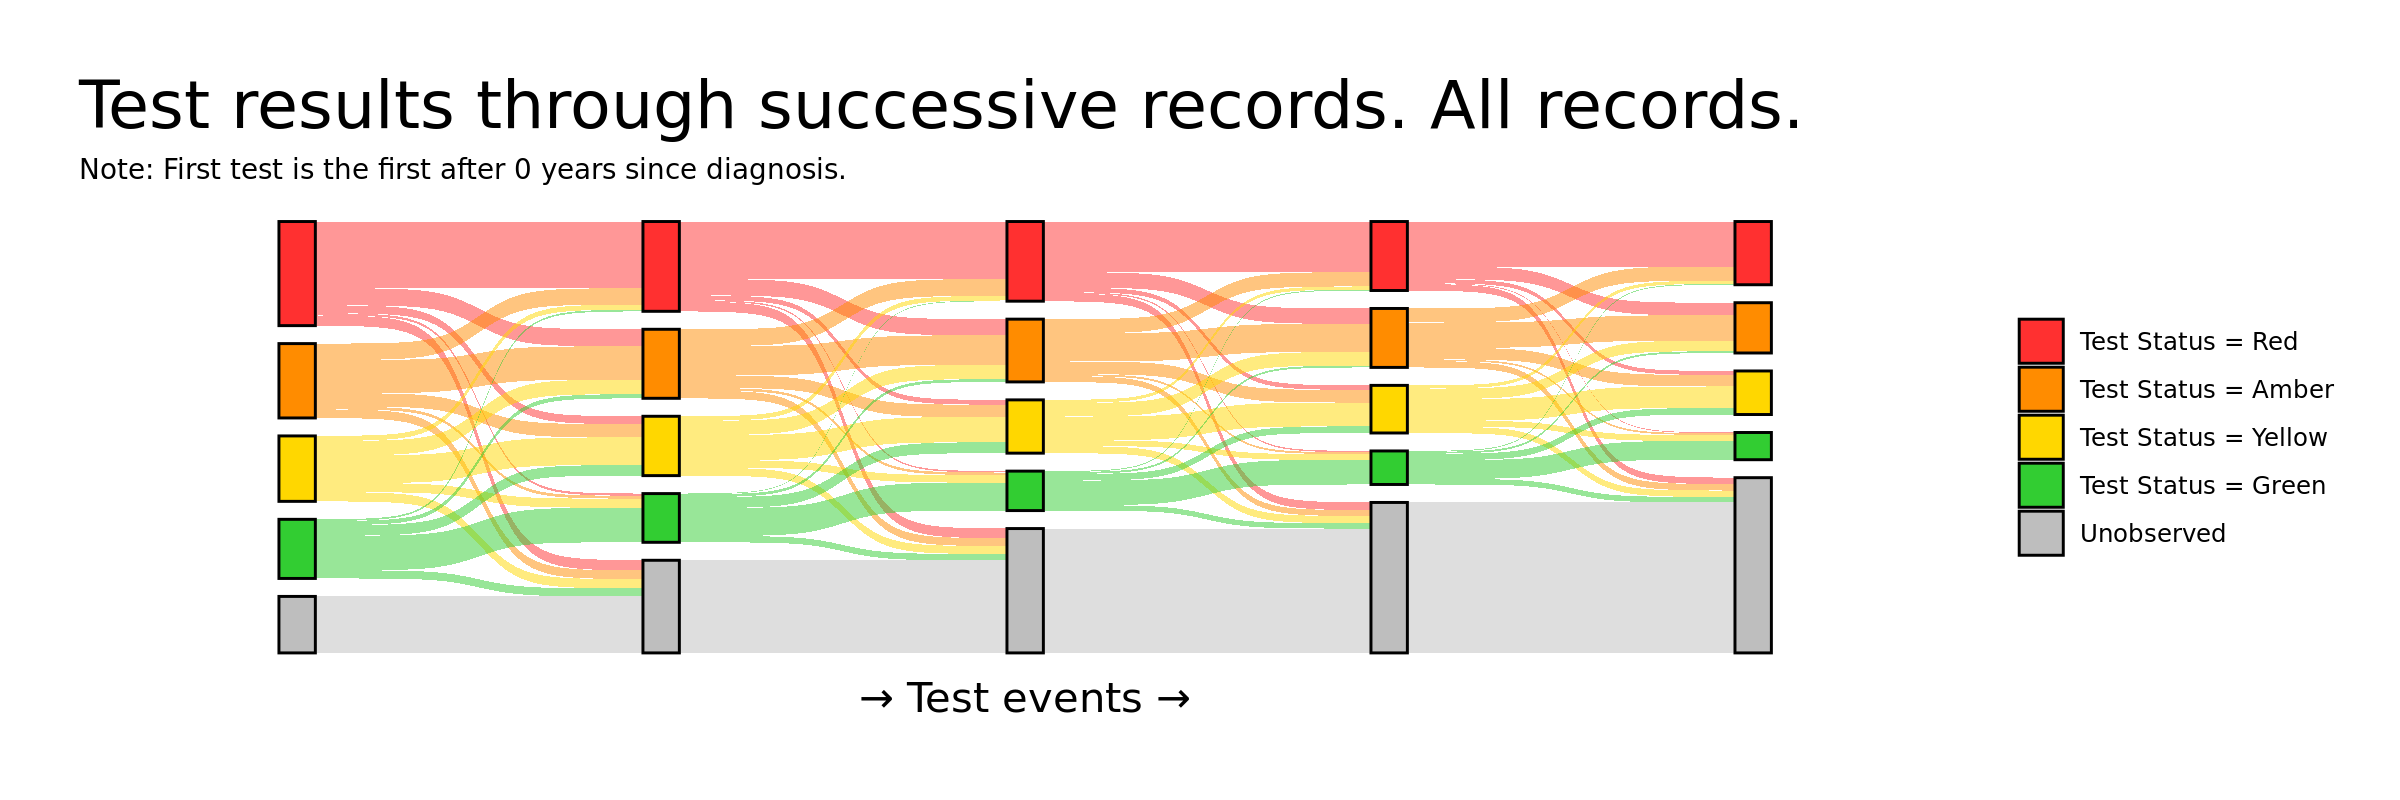

In [23]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )


# PLot.
options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

plot_testStatus_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records. All records."
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_counts

The diagrams below exclude the `Unobserved` state.

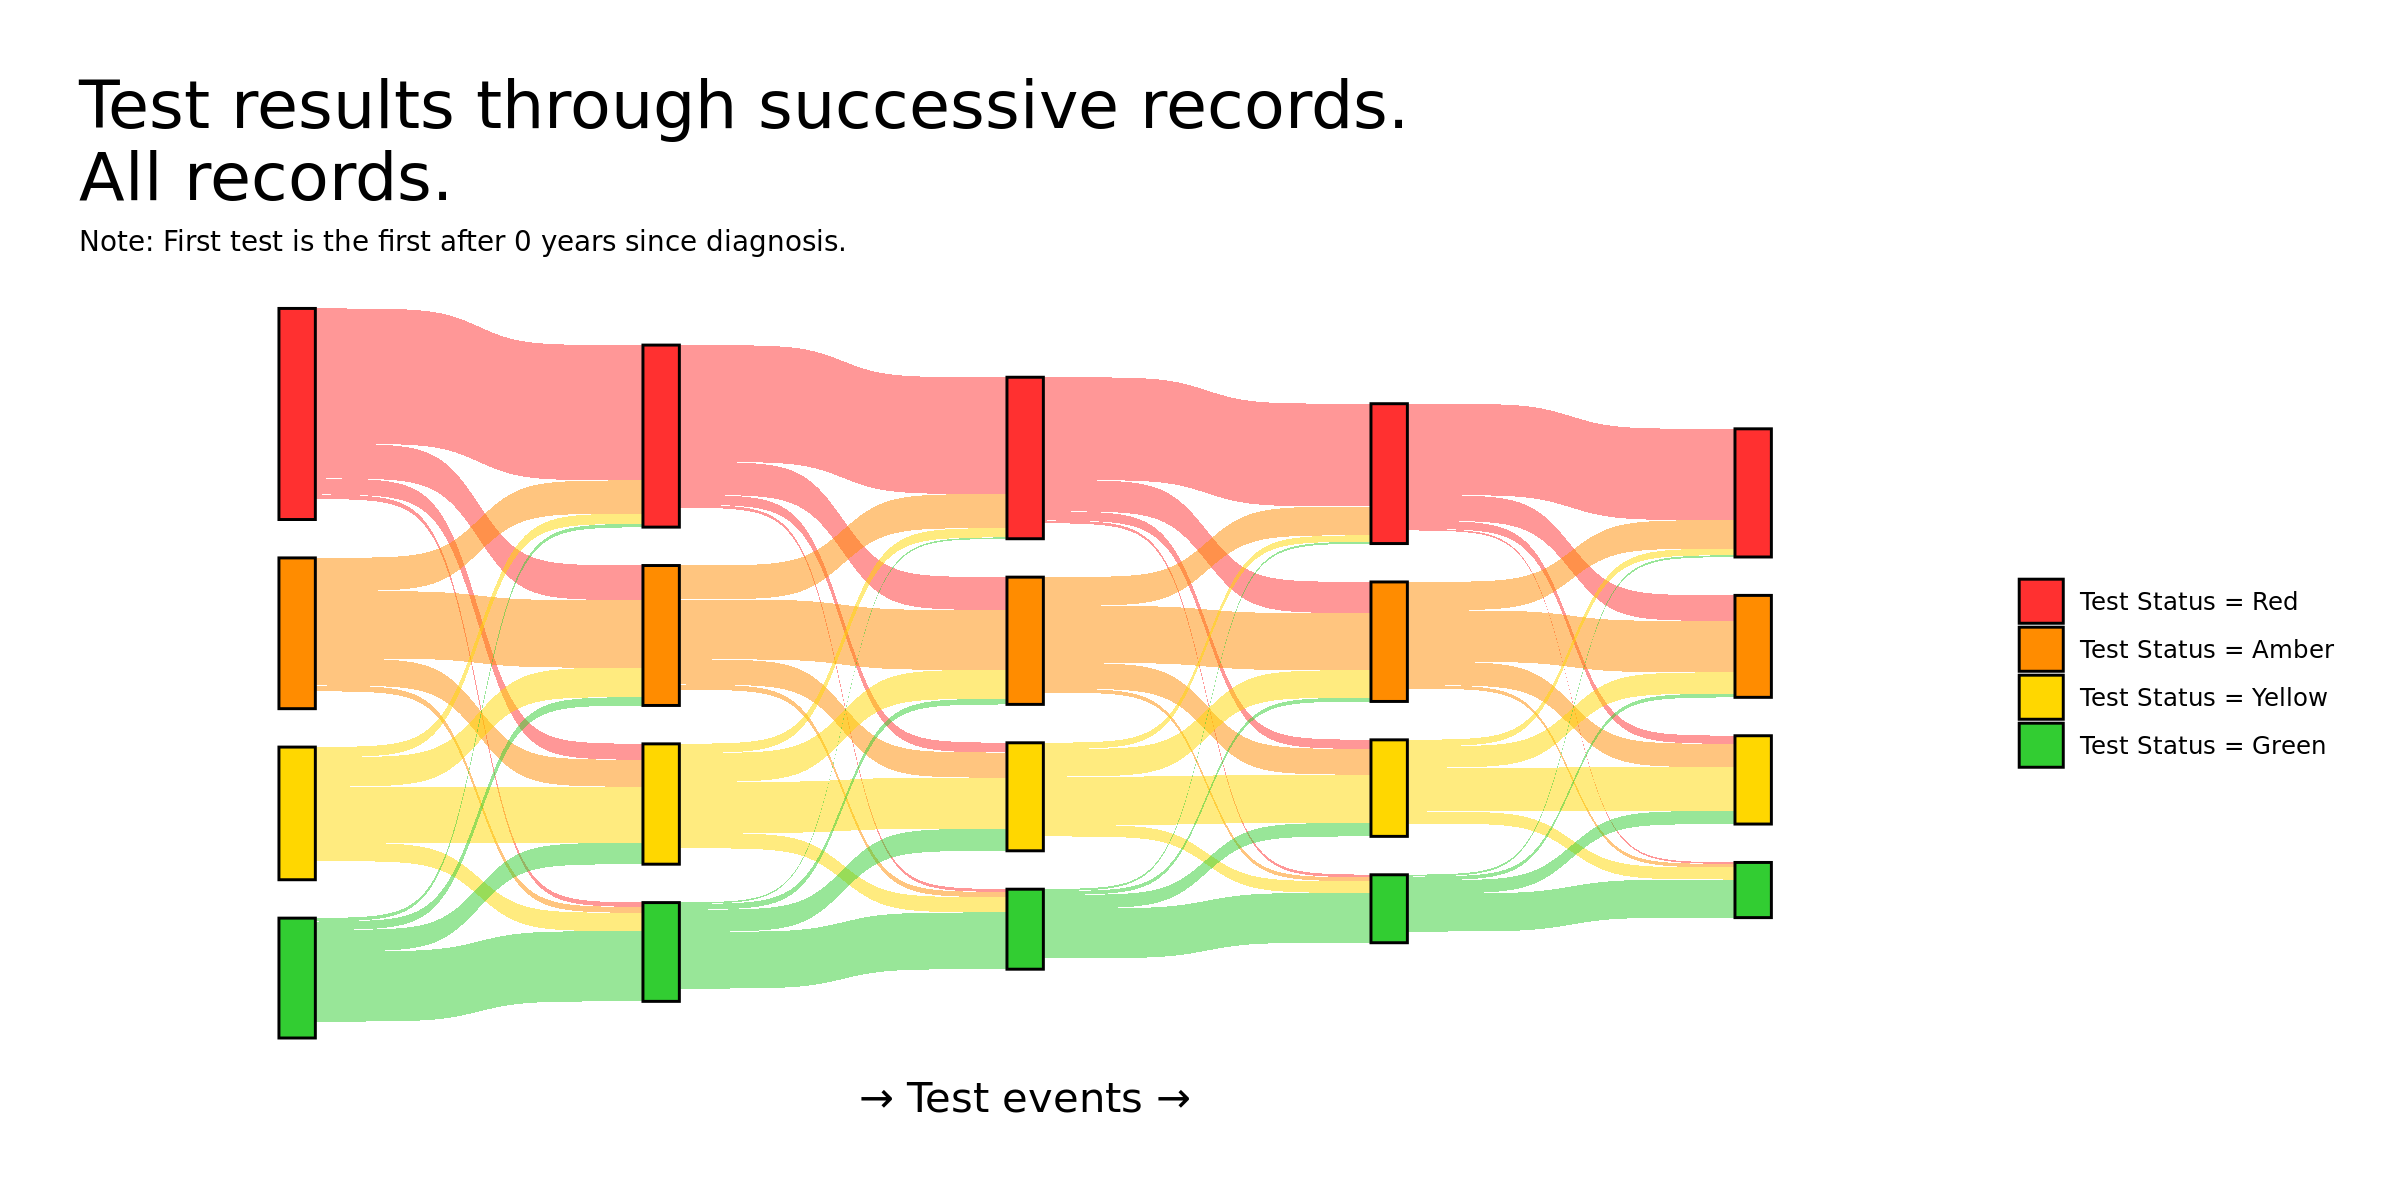

In [33]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )


# PLot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_testStatus_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records.\nAll records."
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_counts

The next three plots don't narrow because they plot data from cohorts that have all five test events. In other words, we have already filtered out any drop outs so the dropouts won't be represented as narrowing. 

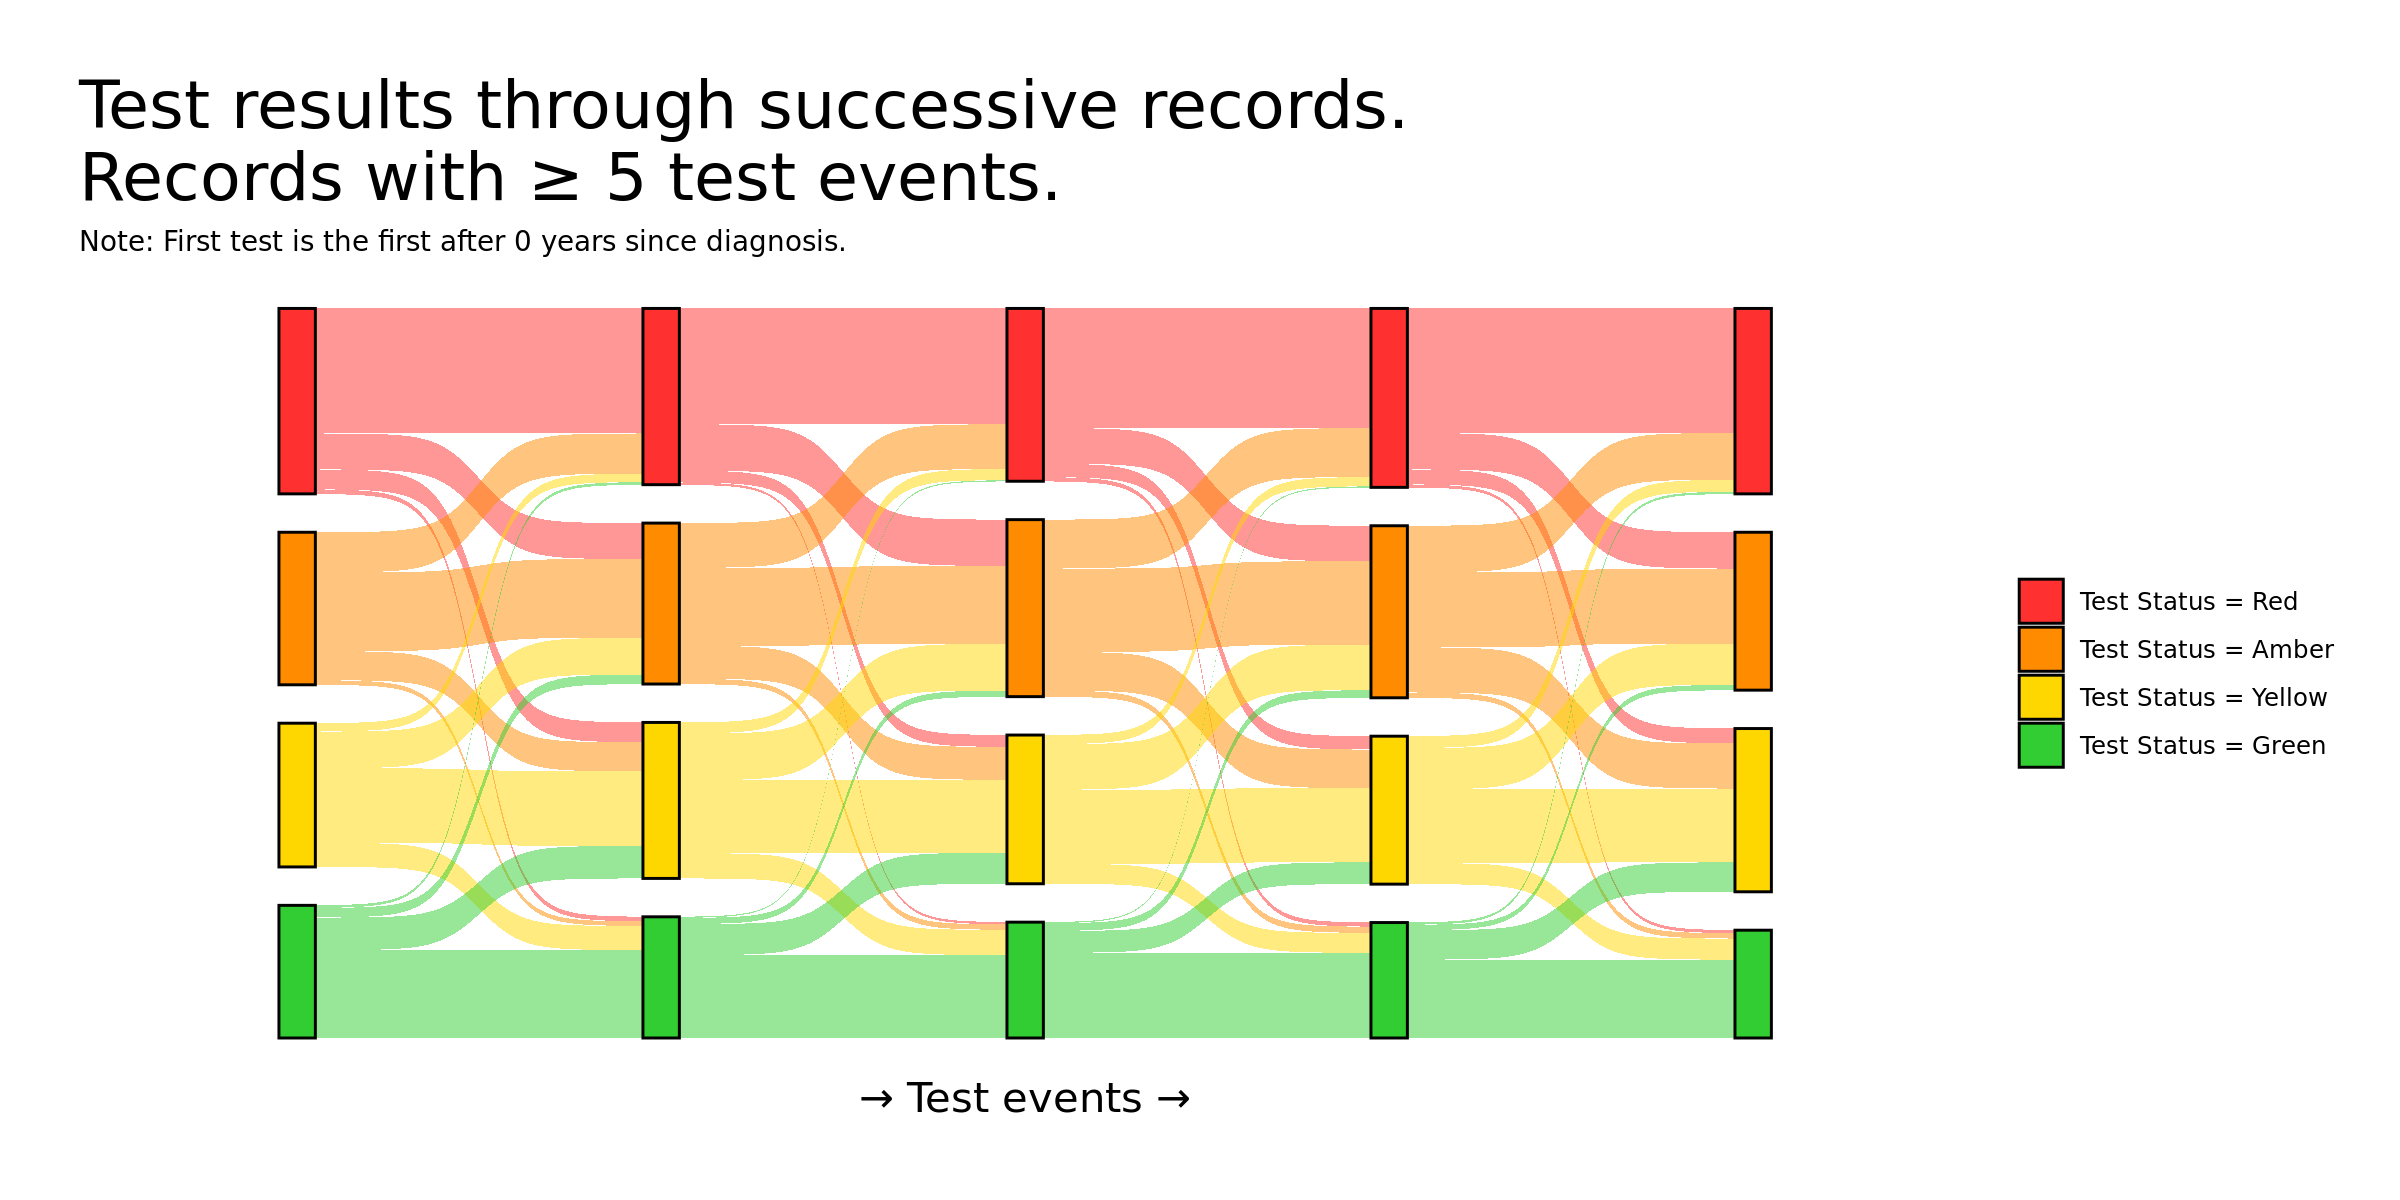

In [31]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    # The following filter for the cohort with 5 or more tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_5 ) %>%
    tibble::column_to_rownames( "person_id" )  %>%
    # Make into the long format
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# PLot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_testStatus_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records.\nRecords with \u2265 5 test events."
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_counts

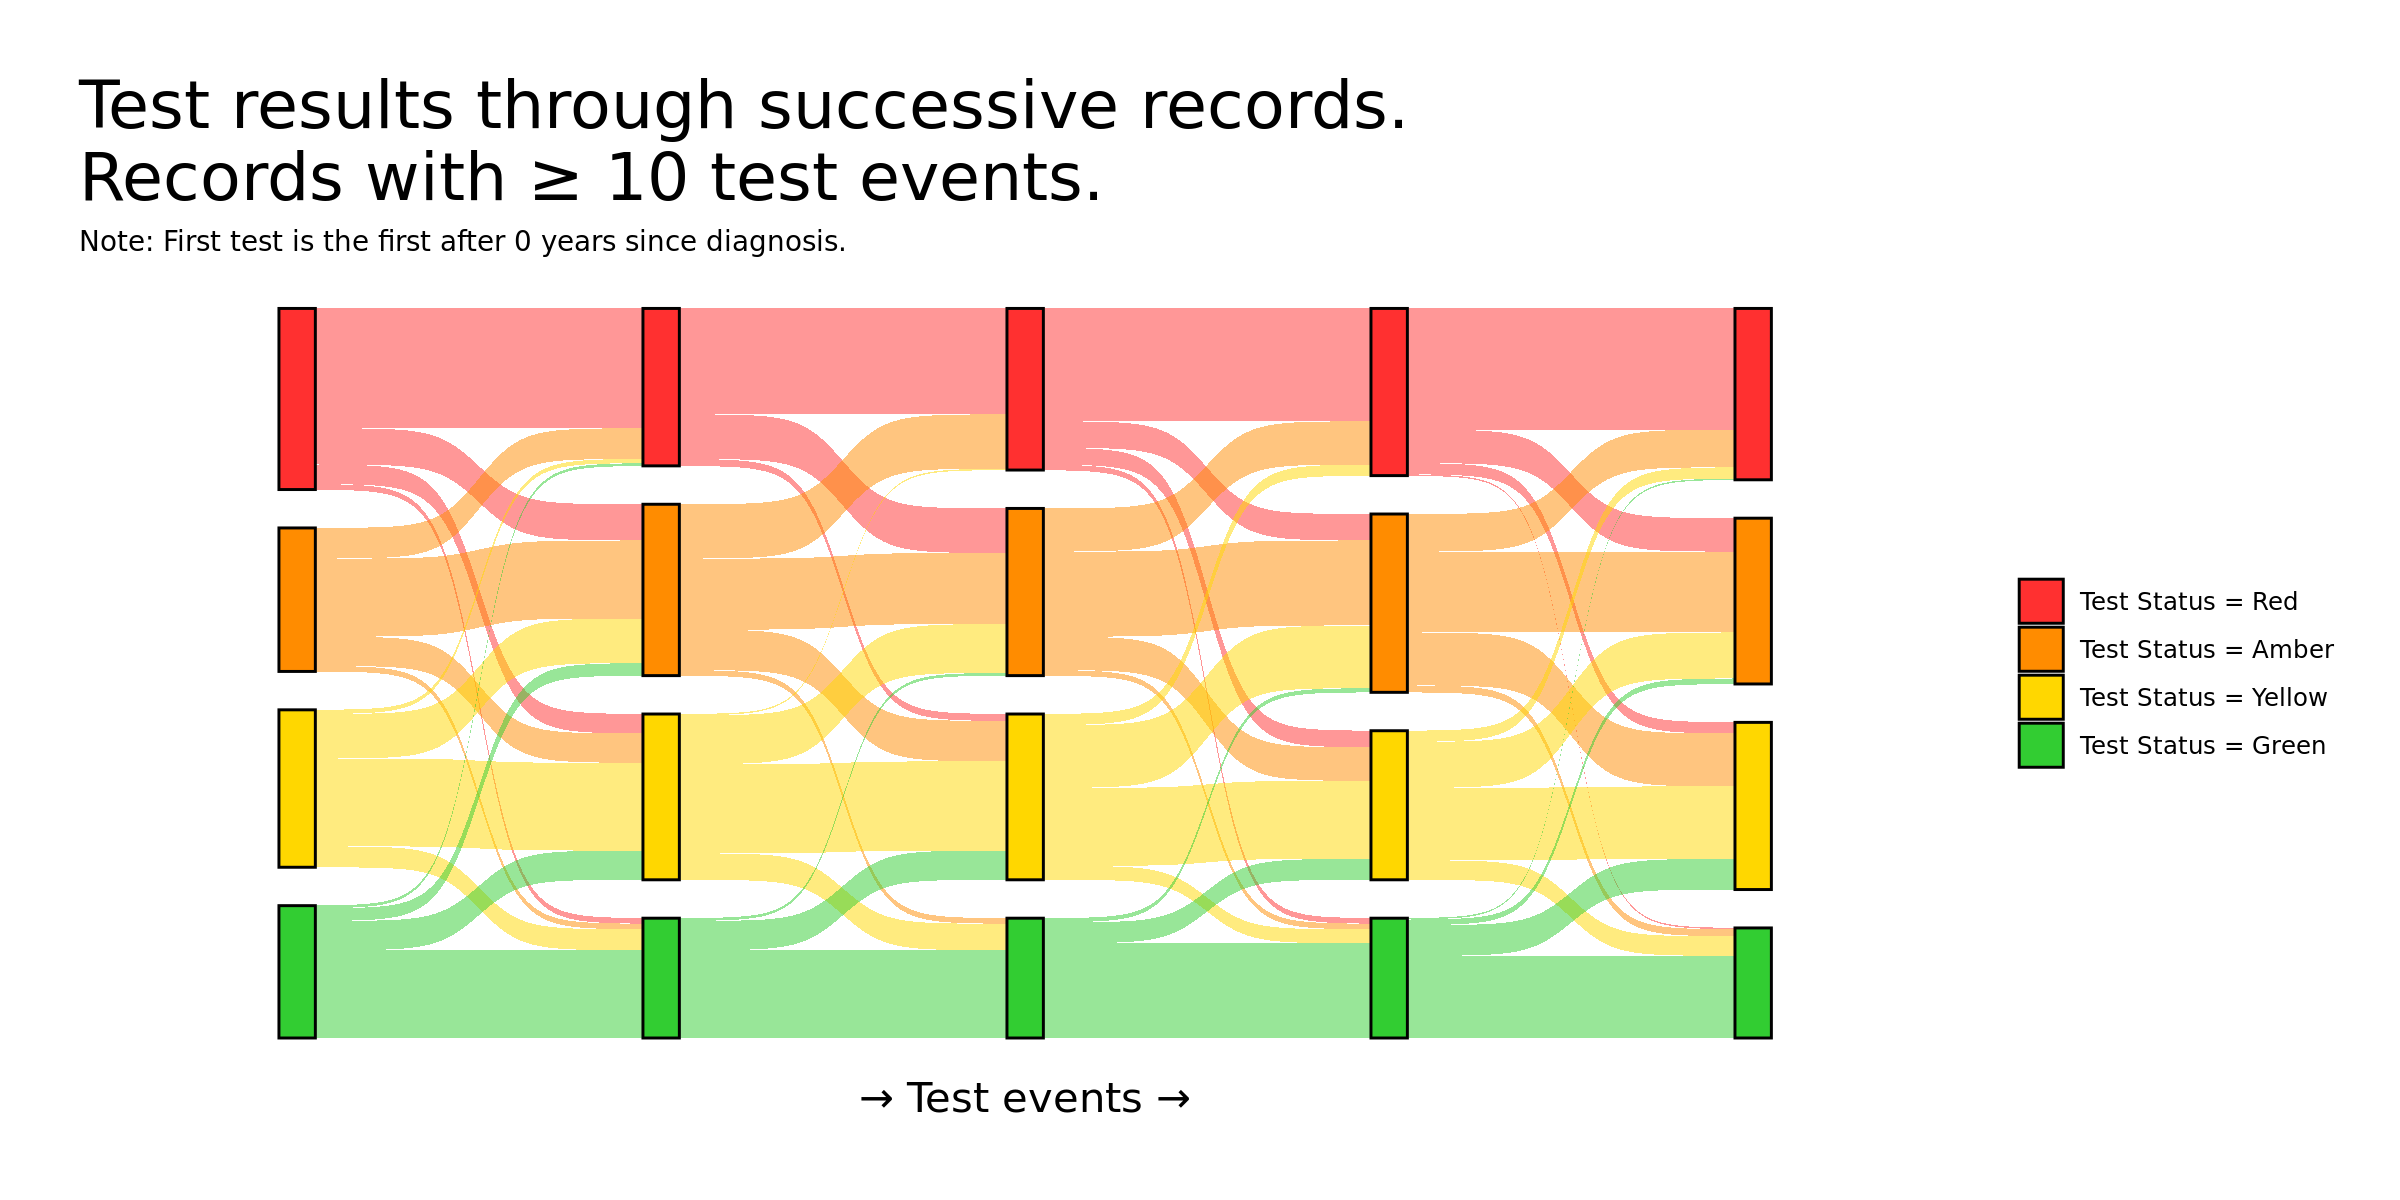

In [30]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    # The following filter for the cohort with 10 or more tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_10 ) %>%
    tibble::column_to_rownames( "person_id" )  %>%
    # Make into the long format
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# PLot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_testStatus_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records.\nRecords with \u2265 10 test events."
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_counts

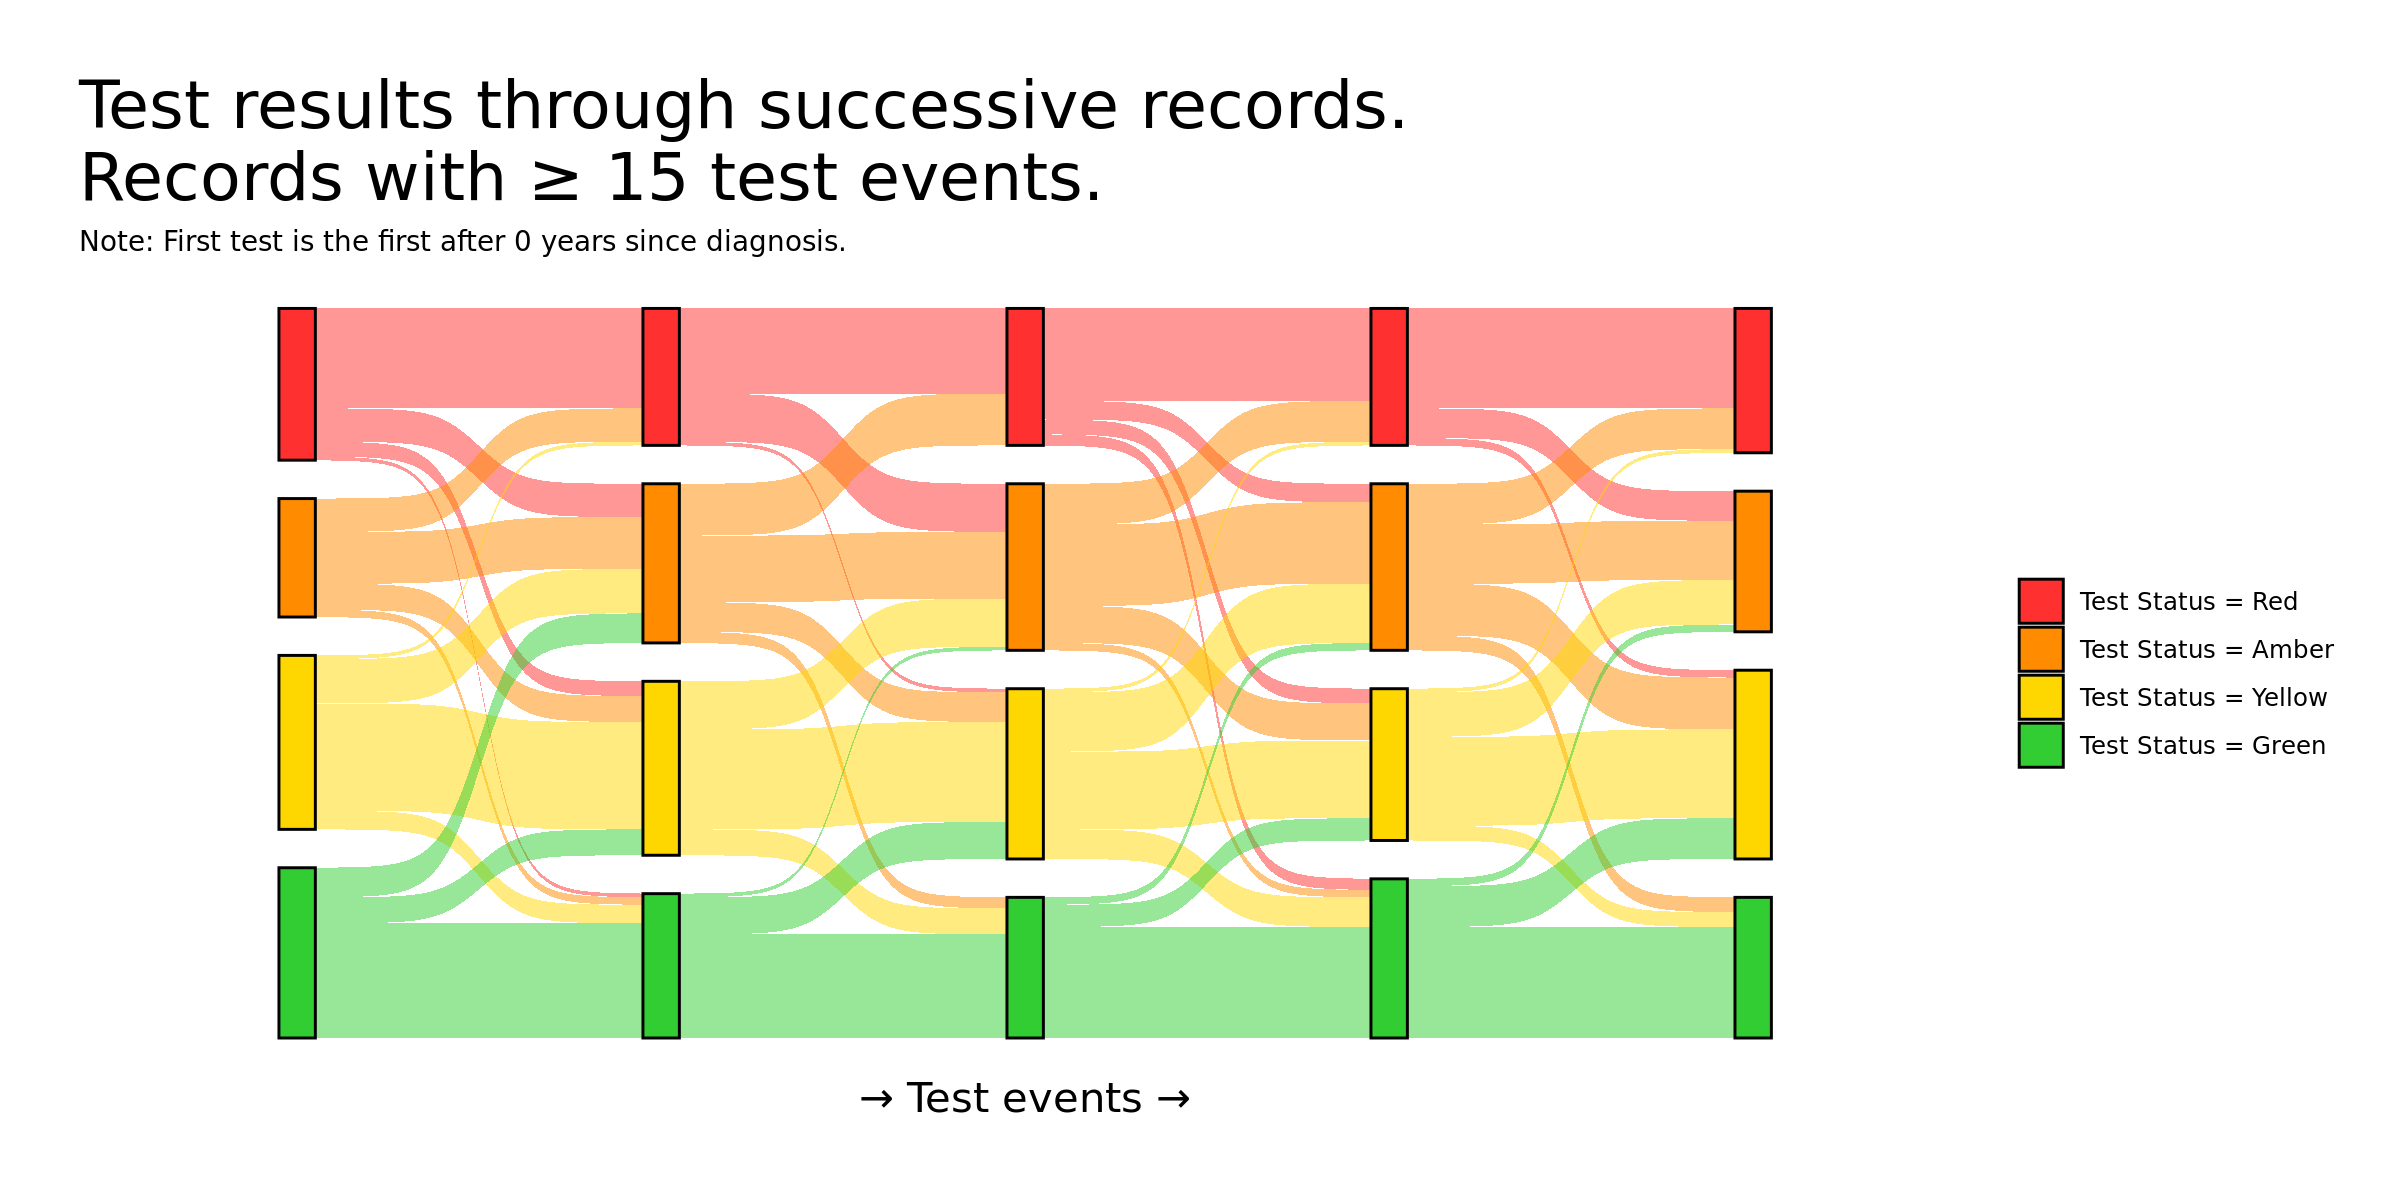

In [29]:
# Make plot data.
plotData <-
    sts_seqmine_test_only %>%
    # The following filter for the cohort with 15 or more tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_15 ) %>%
    tibble::column_to_rownames( "person_id" )  %>%
    # Make into the long format
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# PLot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_testStatus_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    labs(
        title = "Test results through successive records.\nRecords with \u2265 15 test events."
        ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey_counts

#### States strata

In the next plots, I visualise the counts and proportions of patient records moving between states.

There are three infomed by two components: the testing interval since the previous test {'Expected', 'Shorter-than-expected'}, and the change in prescriptions compared with the previous testing interval {'No observed change', 'Observed change'}. The three states are (0,0)-"Hold"; (1,0)-"Monitor"; (0 or 1,1)-"Adjust".


    
I only show the first 5 test events so that all cohorts can be compared, visually.
    
Note that, in the sub-cohort plots, no sequence starts with an `Unobserved` state because the cohort of sequences are defined by having at least 5, 10, or 20 test events.

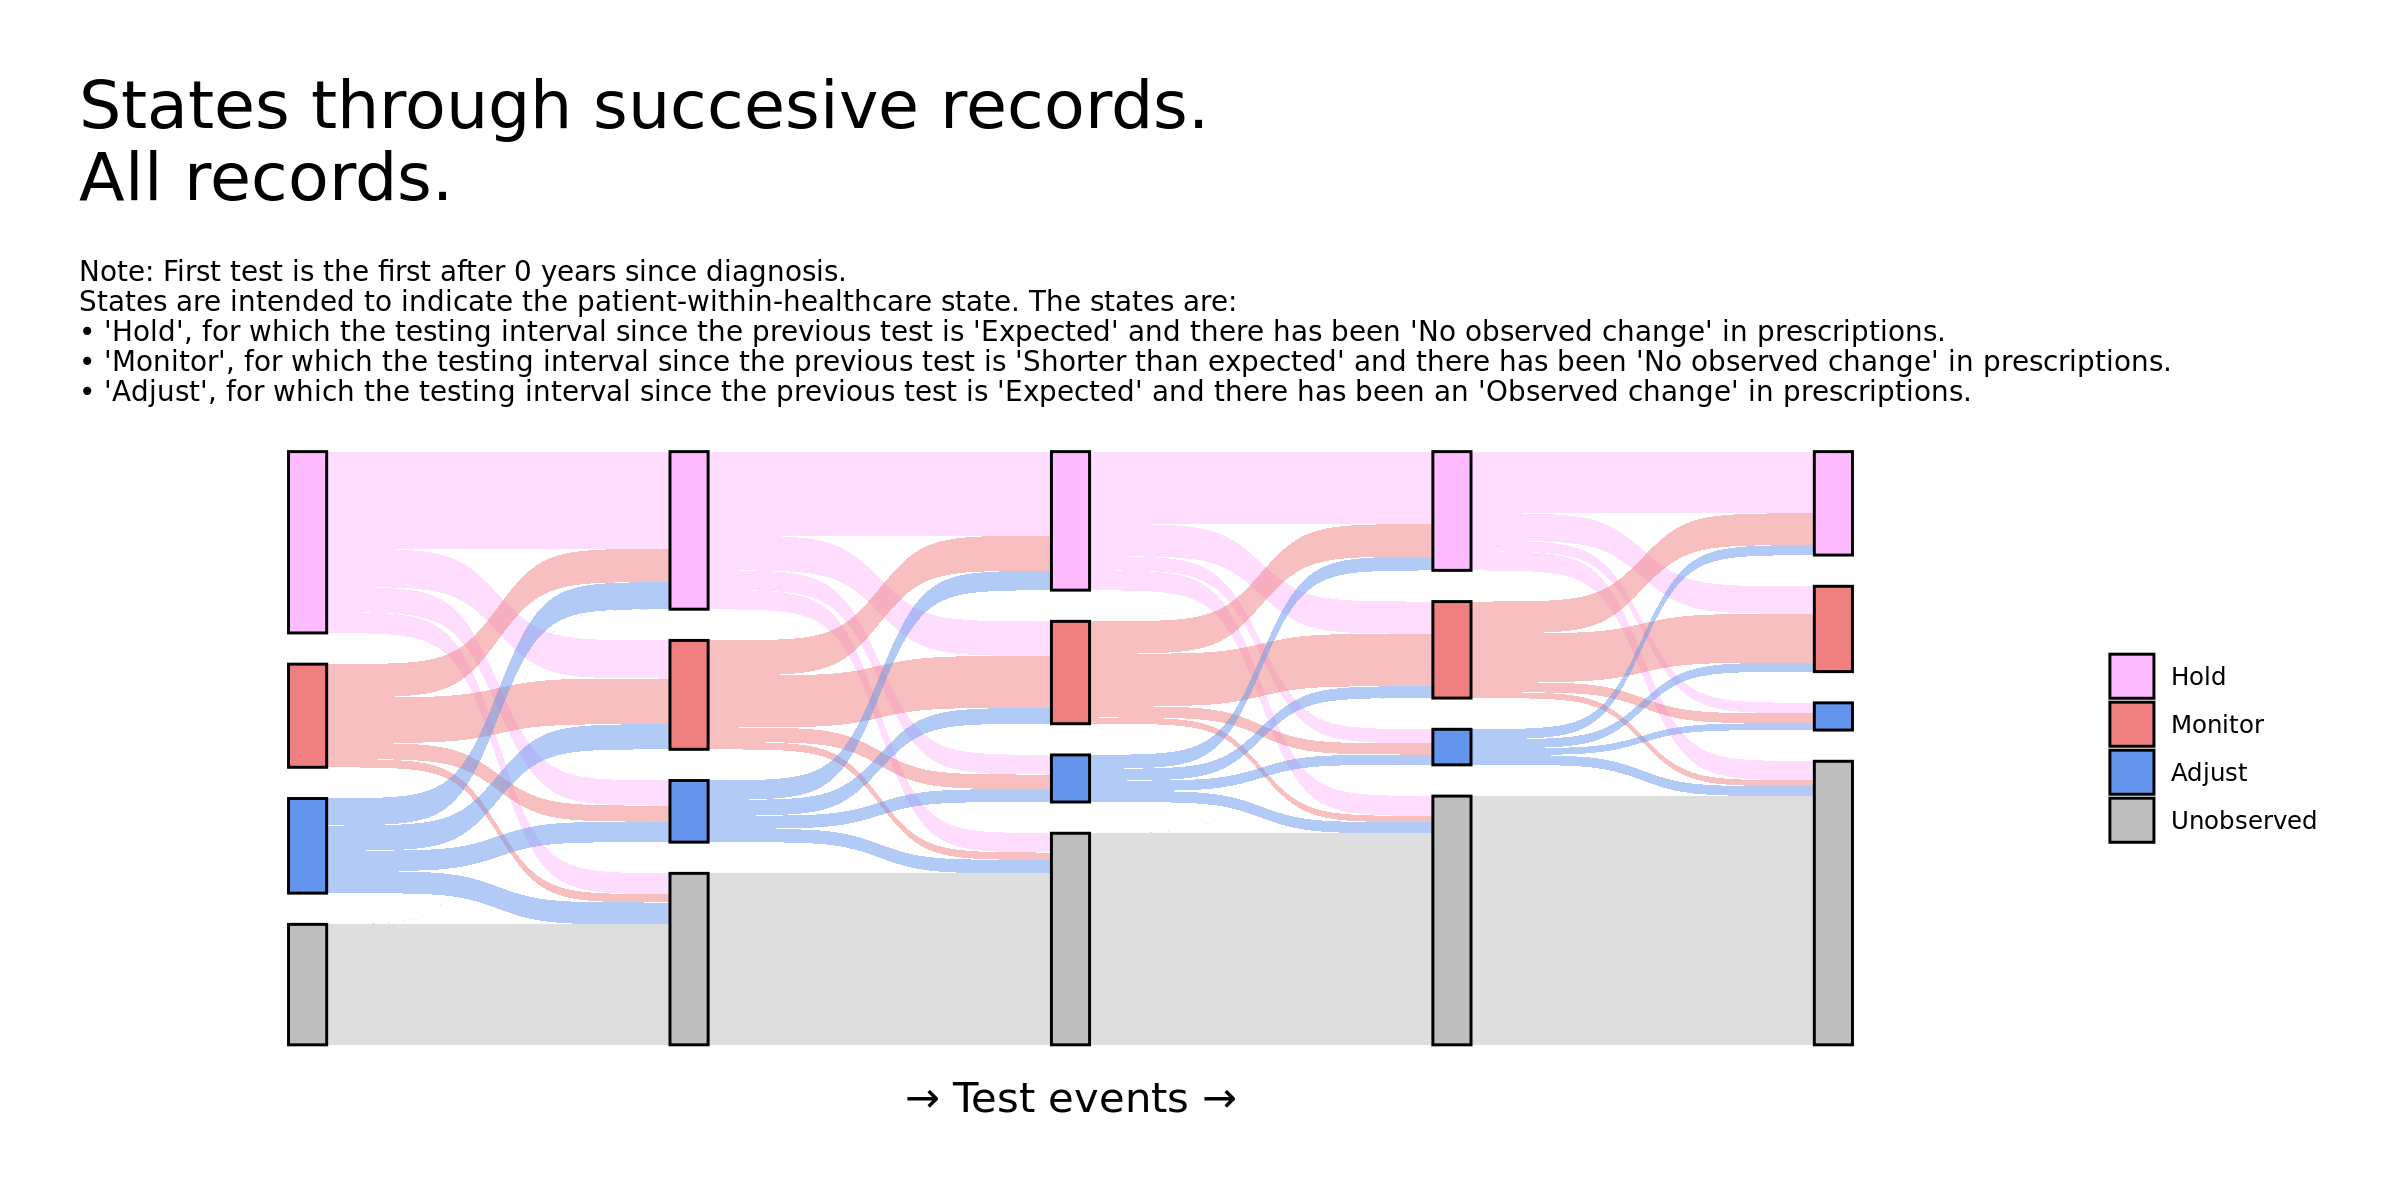

In [34]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
#    ggsankey::geom_sankey_label(
#        aes(
#          x = as.numeric(x) + .05,
#          label = after_stat(paste0(freq))
#        ),
#        size = 8 / .pt, color = "white", fill = "gray40",
#        hjust = 0
#      ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records.\nAll records."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_counts

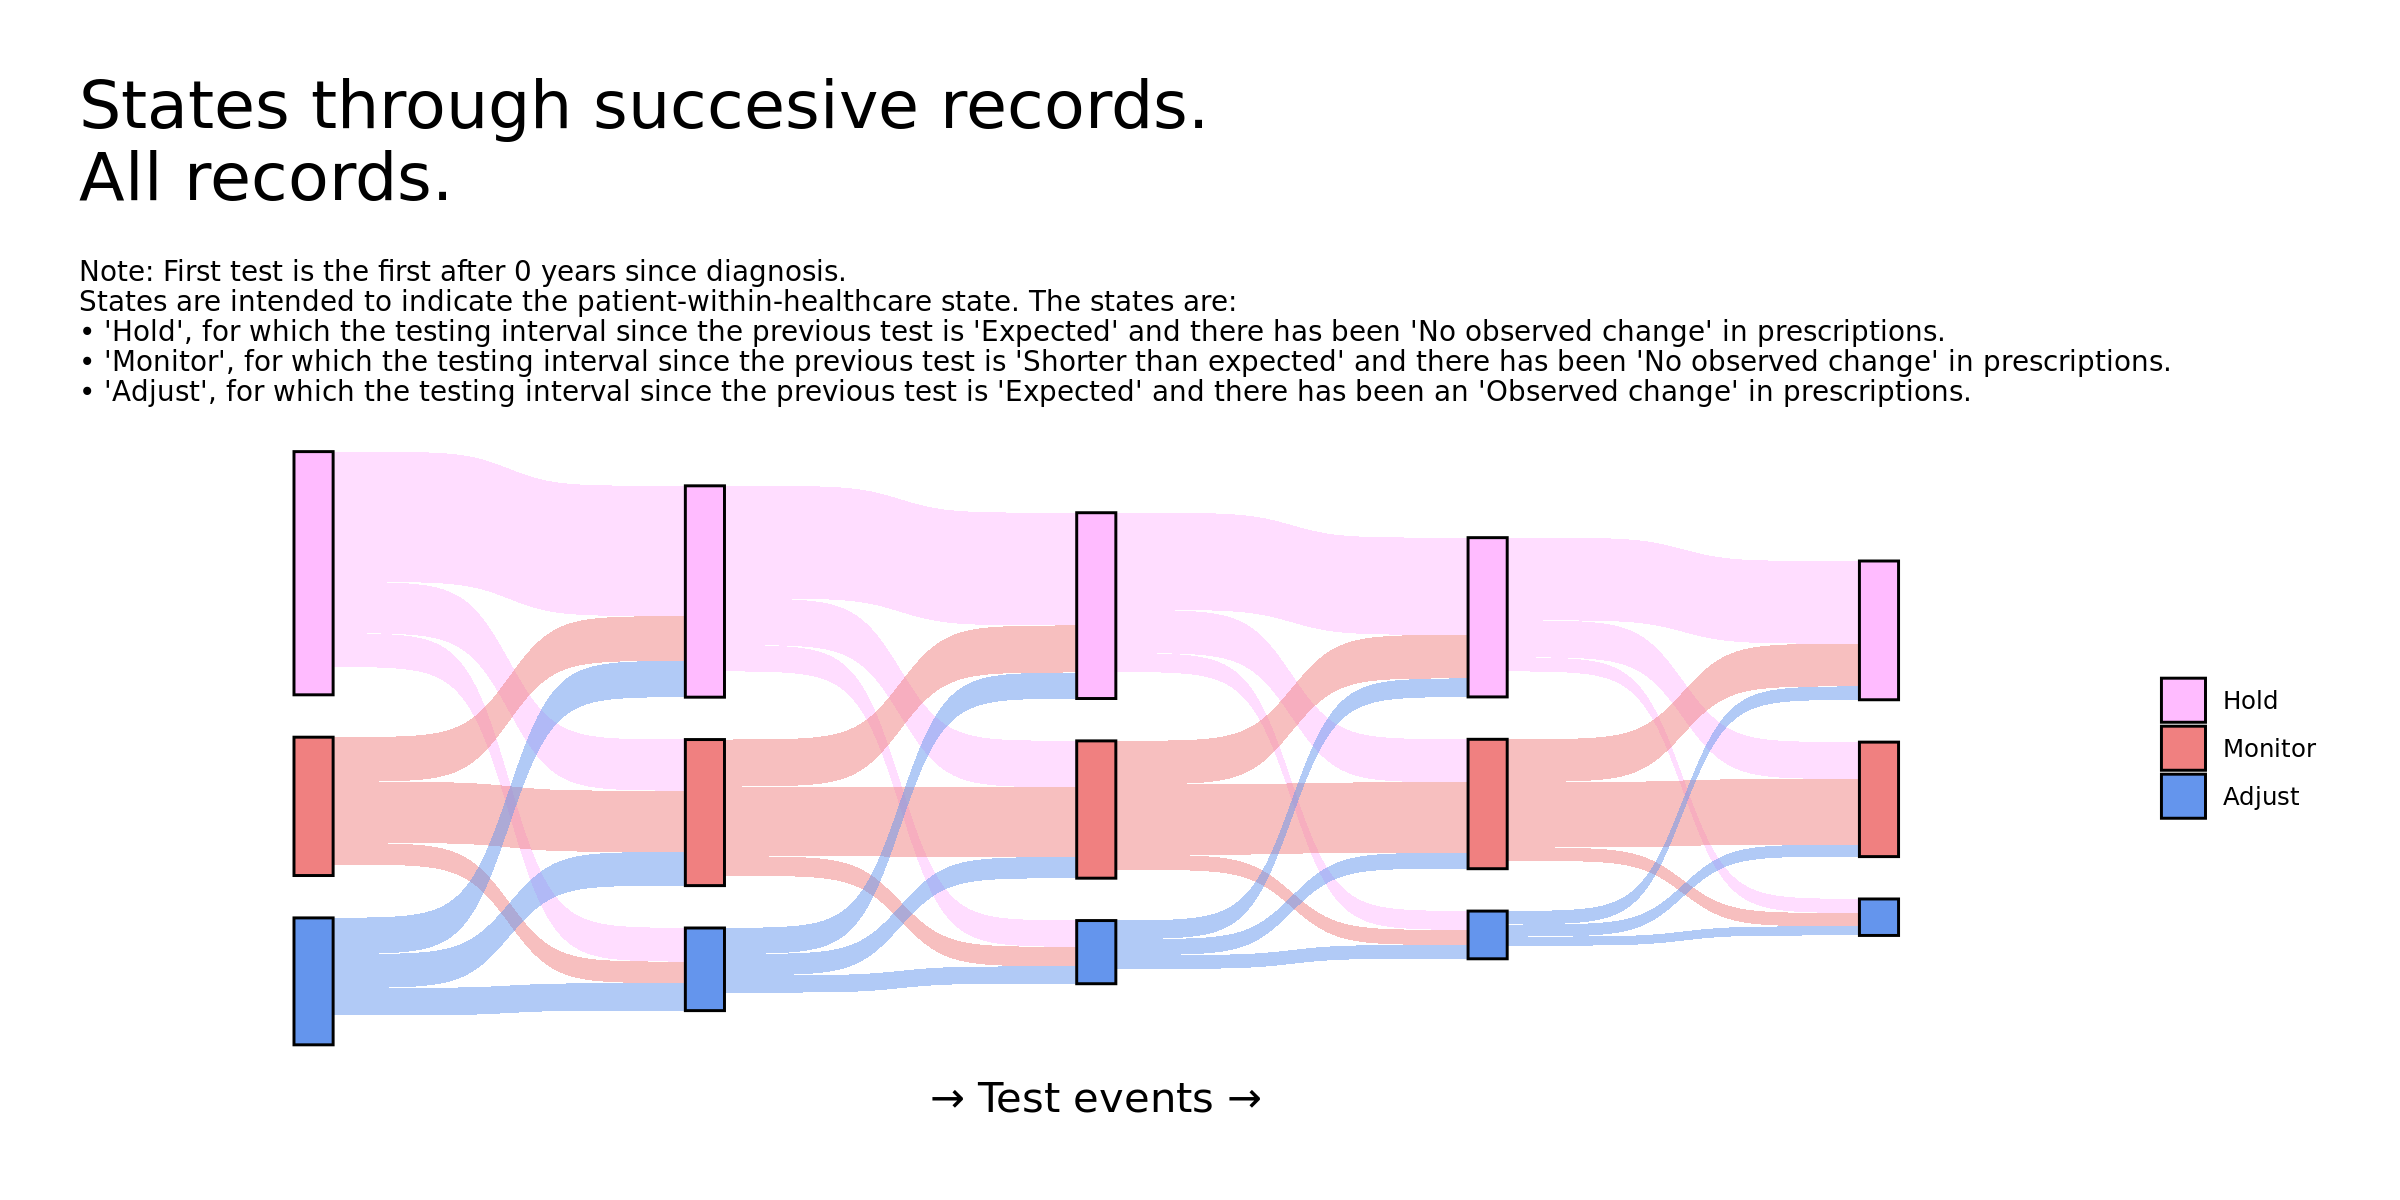

In [38]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records.\nAll records."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_counts

The next three plots don't narrow because they plot data from cohorts that have all five test events. In other words, we have already filtered out any drop outs so the dropouts won't be represented as narrowing. 

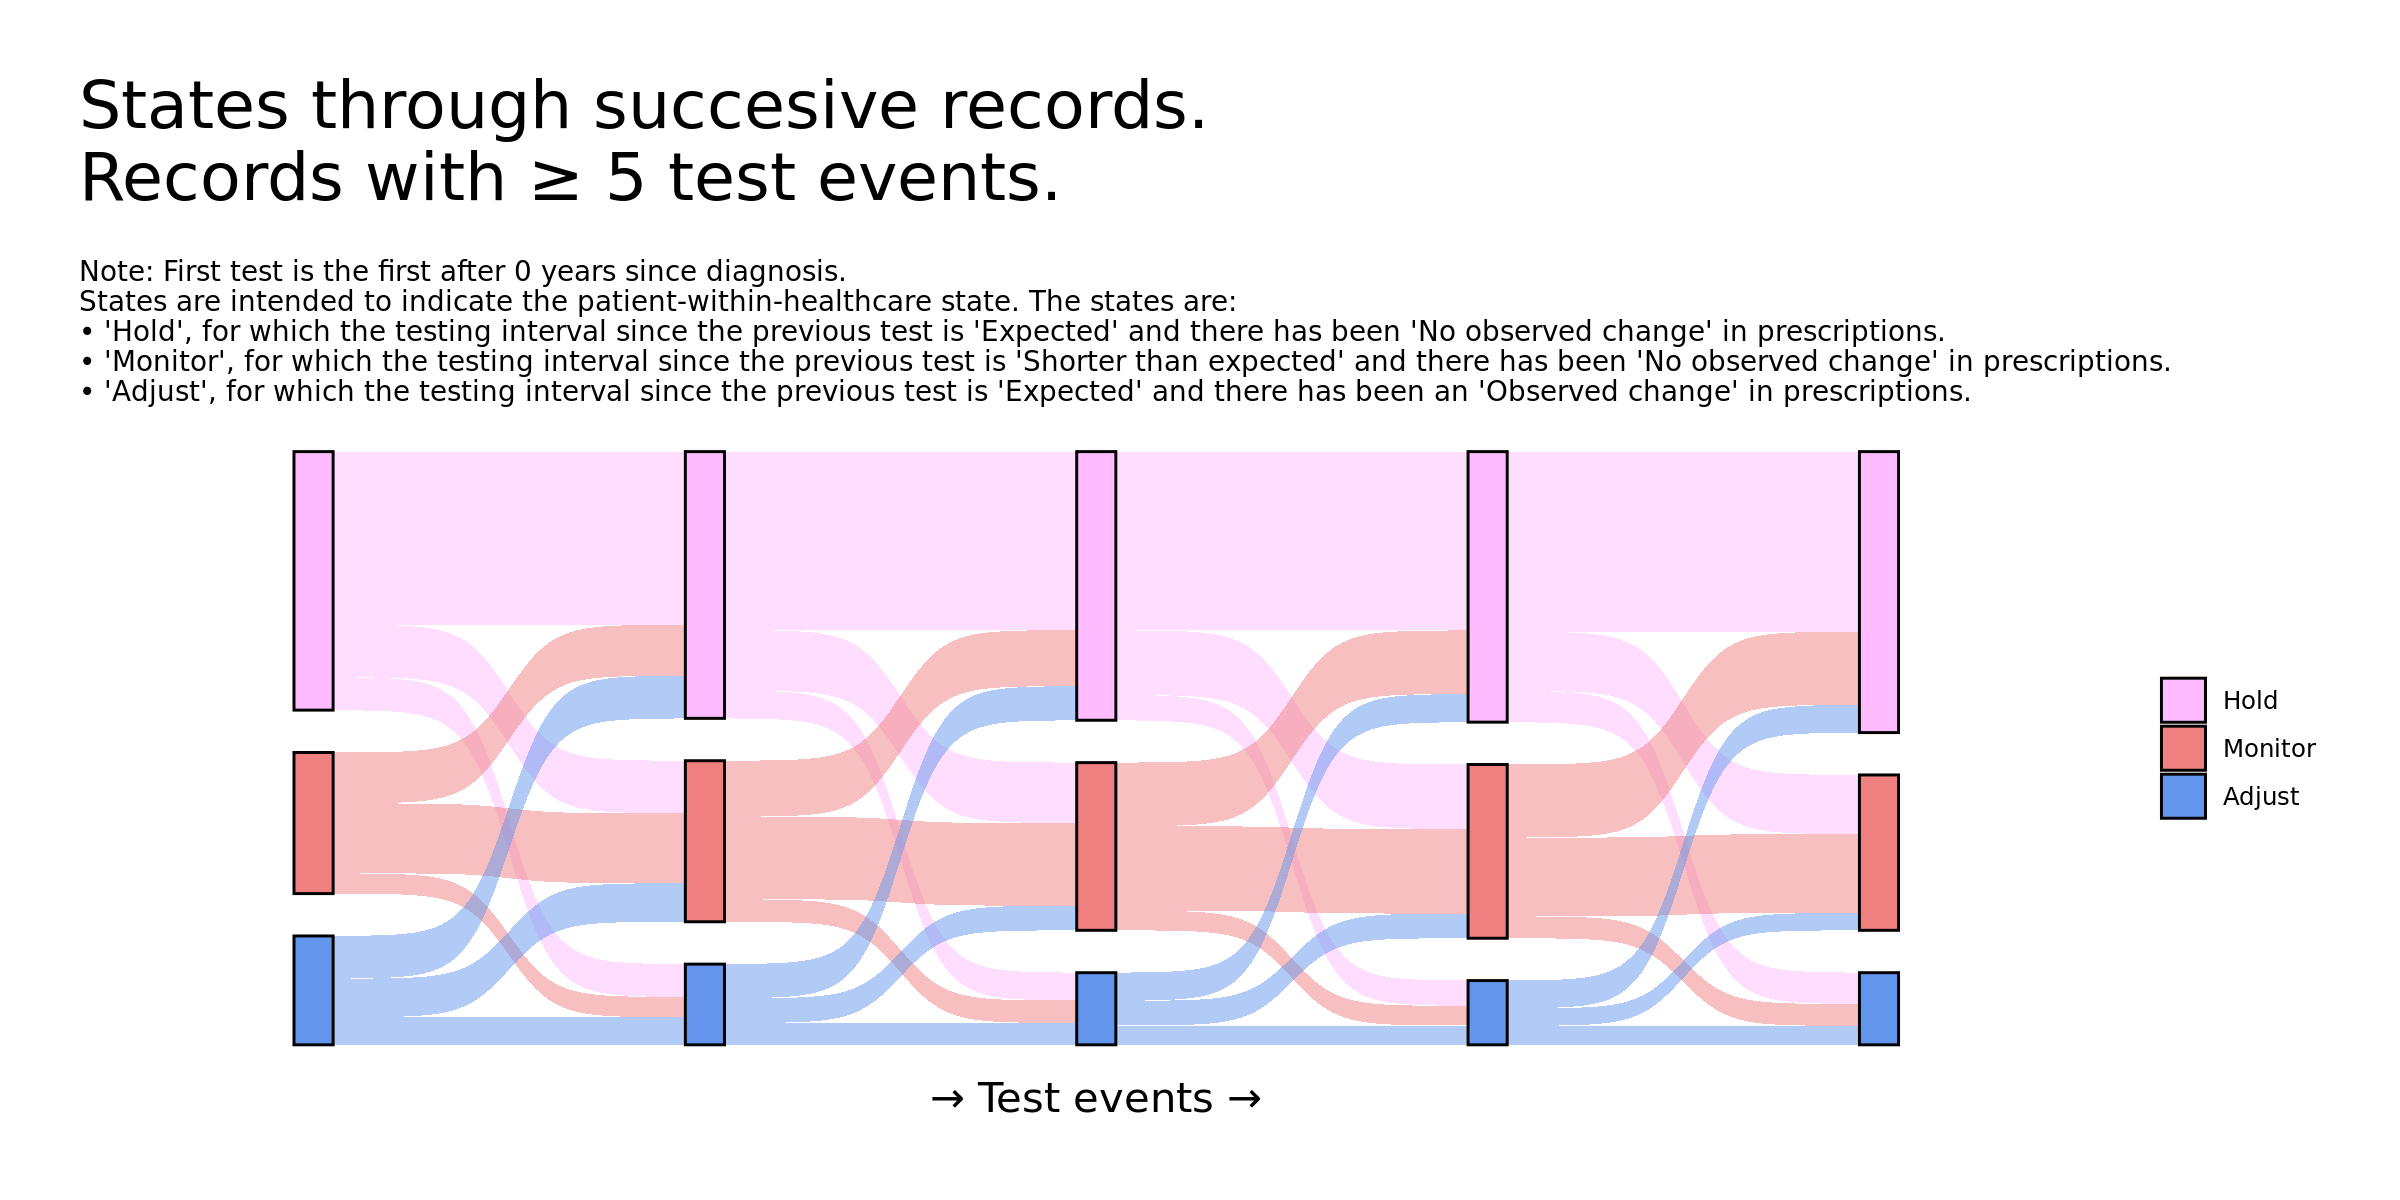

In [35]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    # The following filter for the cohort with 5 or fewer tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_5 ) %>%
    tibble::column_to_rownames( "person_id" ) %>%
    # Make long format.
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
#    ggsankey::geom_sankey_label(
#        aes(
#          x = as.numeric(x) + .05,
#          label = after_stat(paste0(freq))
#        ),
#        size = 8 / .pt, color = "white", fill = "gray40",
#        hjust = 0
#      ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records.\nRecords with \u2265 5 test events."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_counts

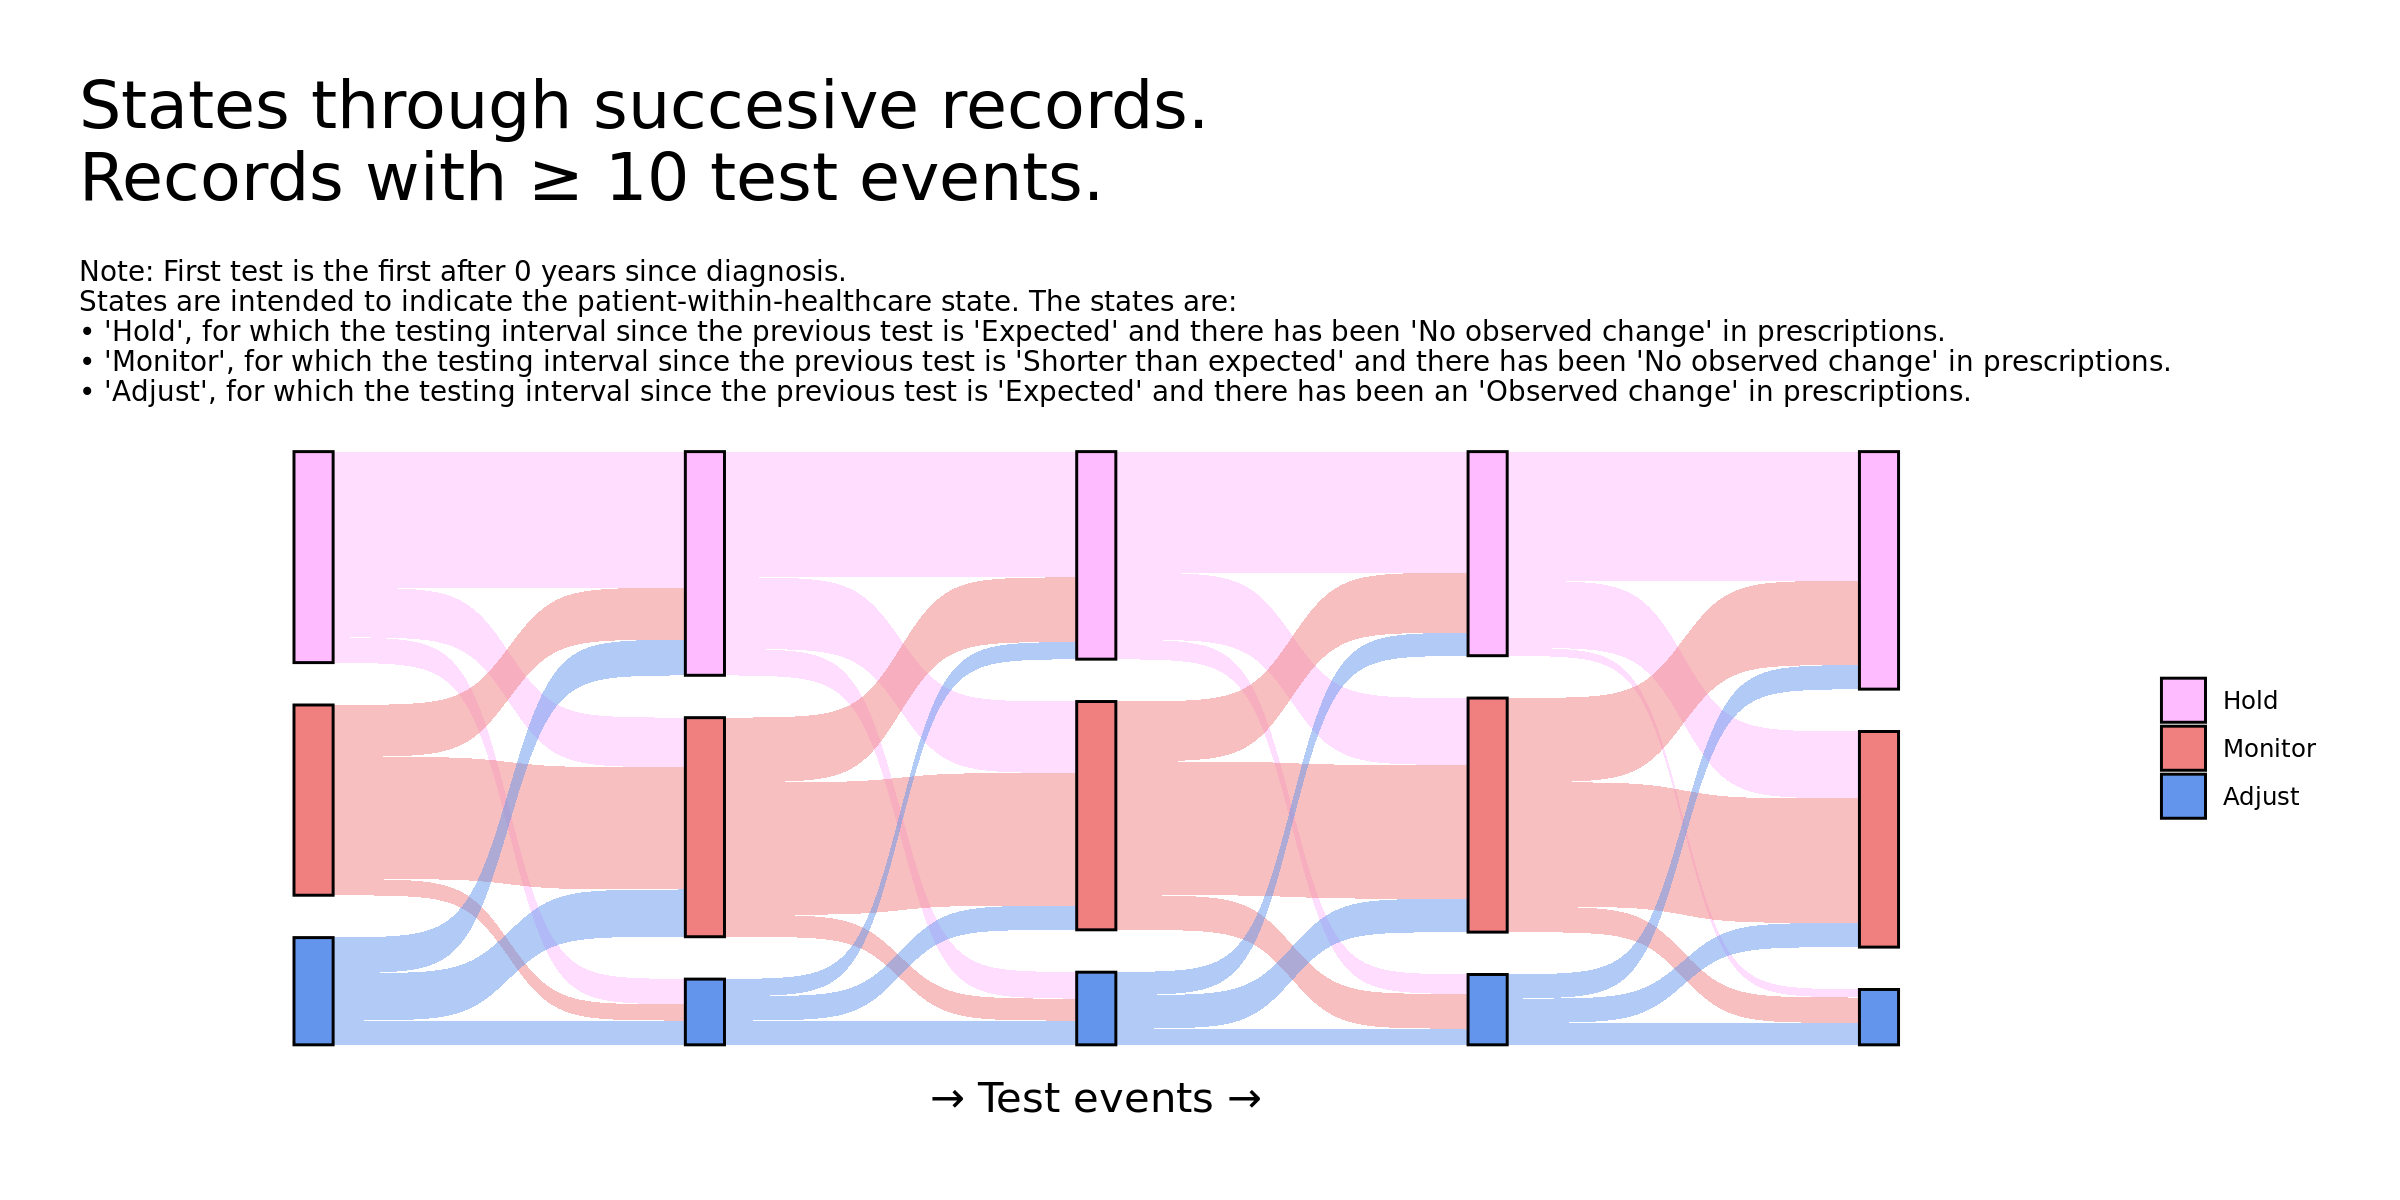

In [36]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    # The following filter for the cohort with 10 or fewer tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_10 ) %>%
    tibble::column_to_rownames( "person_id" ) %>%
    # Make long format.
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
#    ggsankey::geom_sankey_label(
#        aes(
#          x = as.numeric(x) + .05,
#          label = after_stat(paste0(freq))
#        ),
#        size = 8 / .pt, color = "white", fill = "gray40",
#        hjust = 0
#      ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records.\nRecords with \u2265 10 test events."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_counts

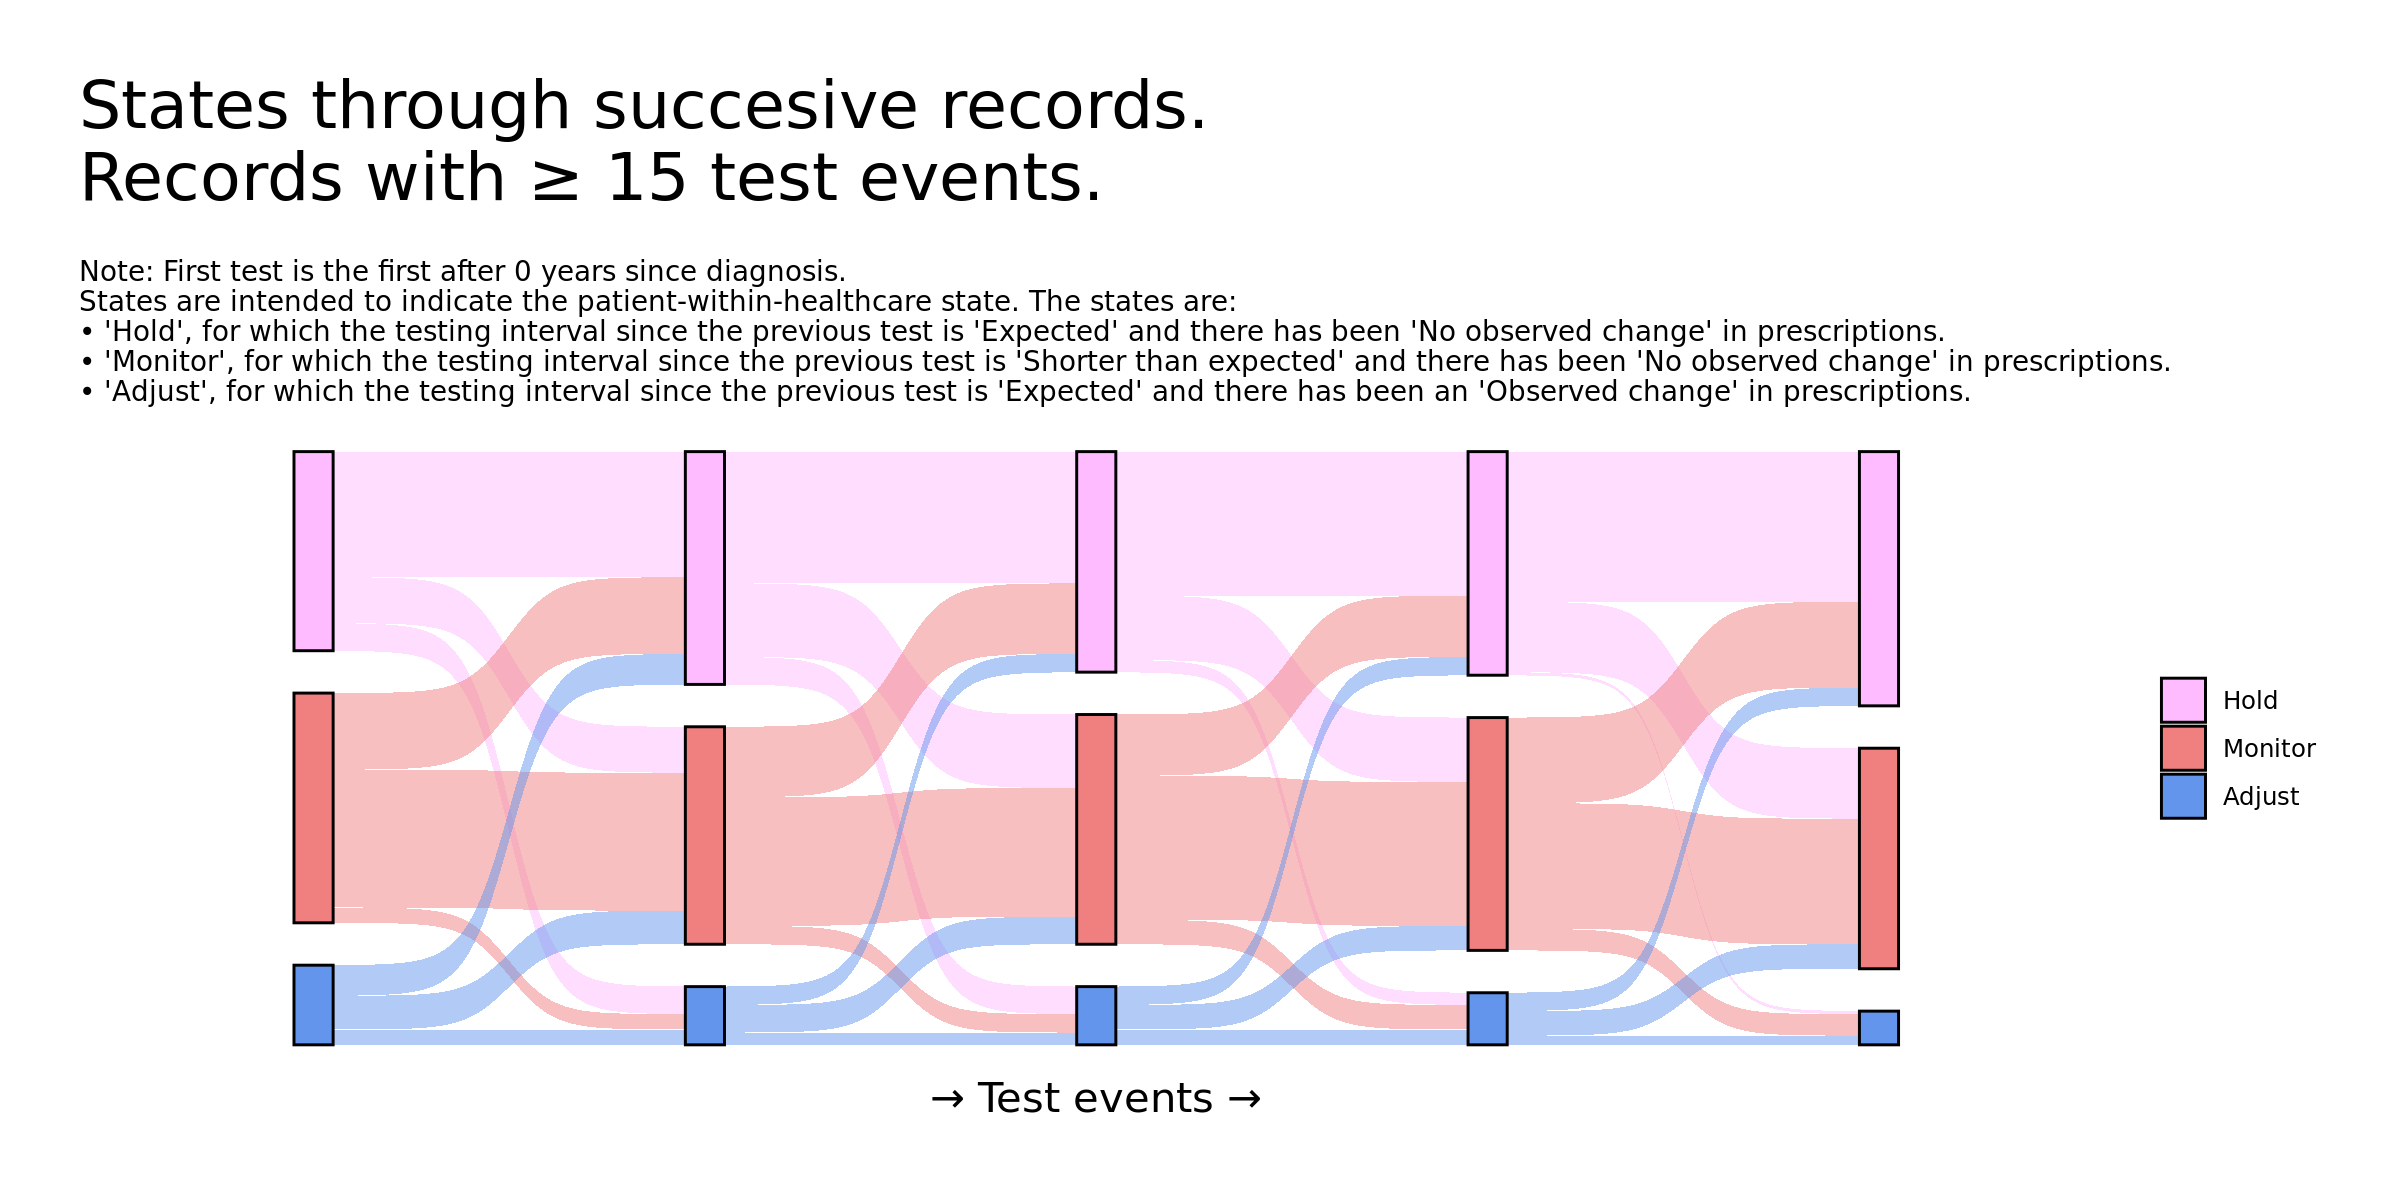

In [37]:
# Make plot data.
plotData <-
    sts_seqmine_HMA %>%
    # The following filter for the cohort with 20 or fewer tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_15 ) %>%
    tibble::column_to_rownames( "person_id" ) %>%
    # Make long format.
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_HMA_Sankey_counts <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
#    ggsankey::geom_sankey_label(
#        aes(
#          x = as.numeric(x) + .05,
#          label = after_stat(paste0(freq))
#        ),
#        size = 8 / .pt, color = "white", fill = "gray40",
#        hjust = 0
#      ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual(
        values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
        ,labels = c( "Hold", "Monitor", "Adjust", "Unobserved" )
    ) +
    labs(
        title = "States through succesive records.\nRecords with \u2265 15 test events."
       ,subtitle = paste0(
            paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.\n")
            ,"States are intended to indicate the patient-within-healthcare state. The states are:\n"
            ,"\u2022 'Hold', for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Monitor', for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.\n"
            ,"\u2022 'Adjust', for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,legend.title = element_blank()
        )

plot_HMA_Sankey_counts

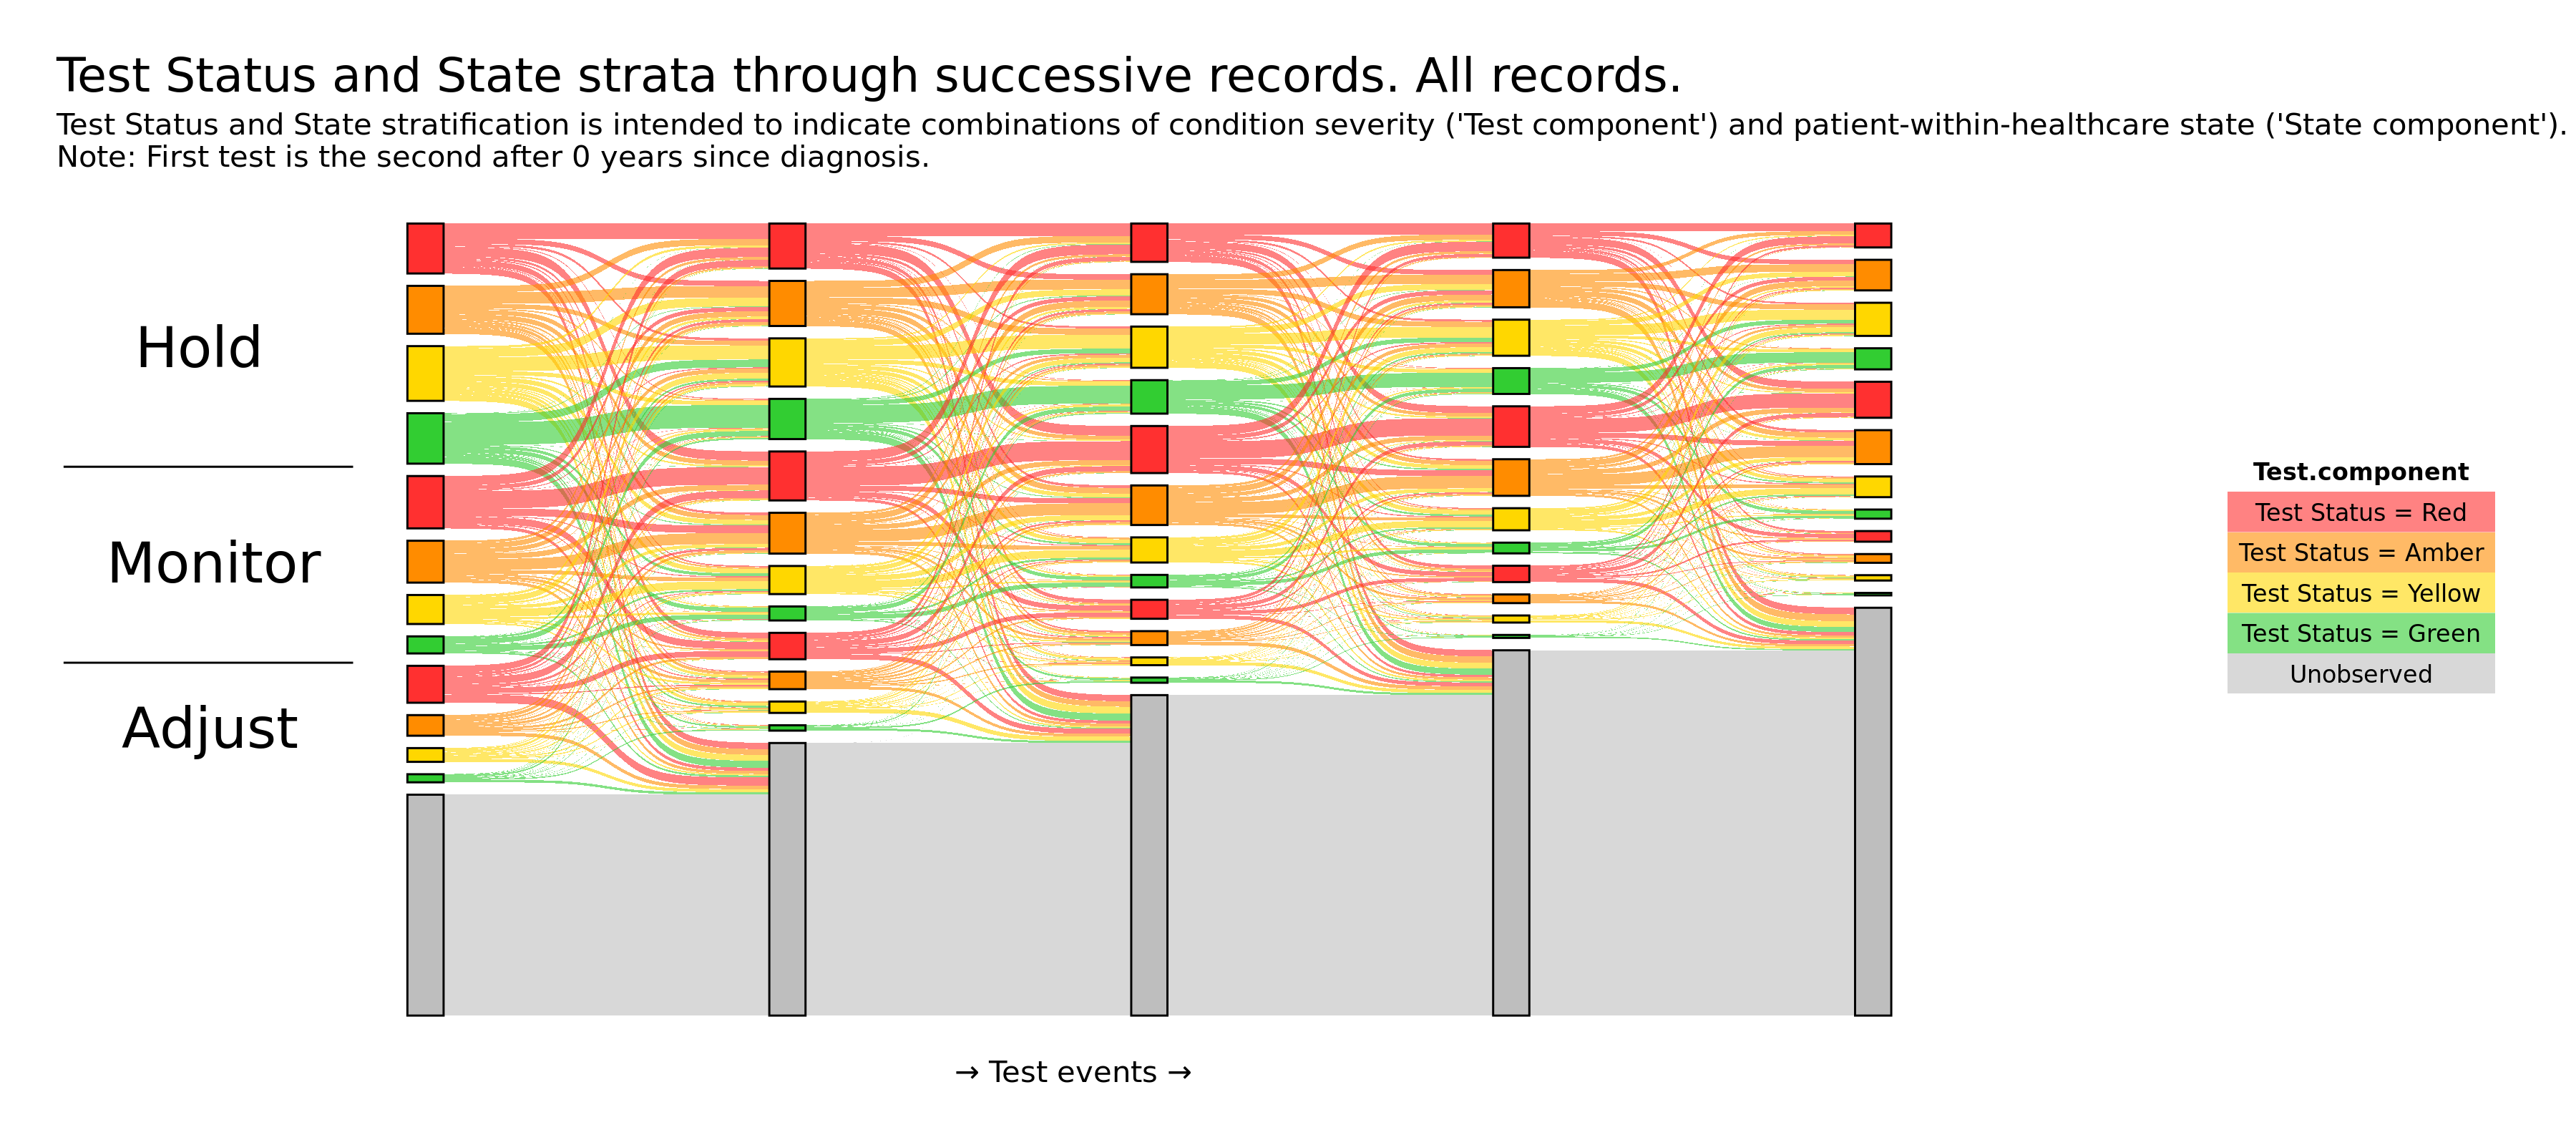

In [40]:
#### Test Status and State strata

#  the next plots, I visualise the counts and proportions of patient records moving through test statues and state.

# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a3", "a4", "a5", "a6", "a7") )

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate( group = 1 ) %>%
    dplyr::select( - next_x, - next_node, - next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
n_patients_Unobserved_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Unobserved" ) ) %>% nrow()
y_segment_Adjust <- n_patients_Adjust_at_start + n_patients_Unobserved_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -0.02, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = 0.02, label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = 0.01, label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records. All records."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,paste0("Note: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    HMAandTestStatus_display_table %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_tail( n = 5 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_counts <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_counts ) )

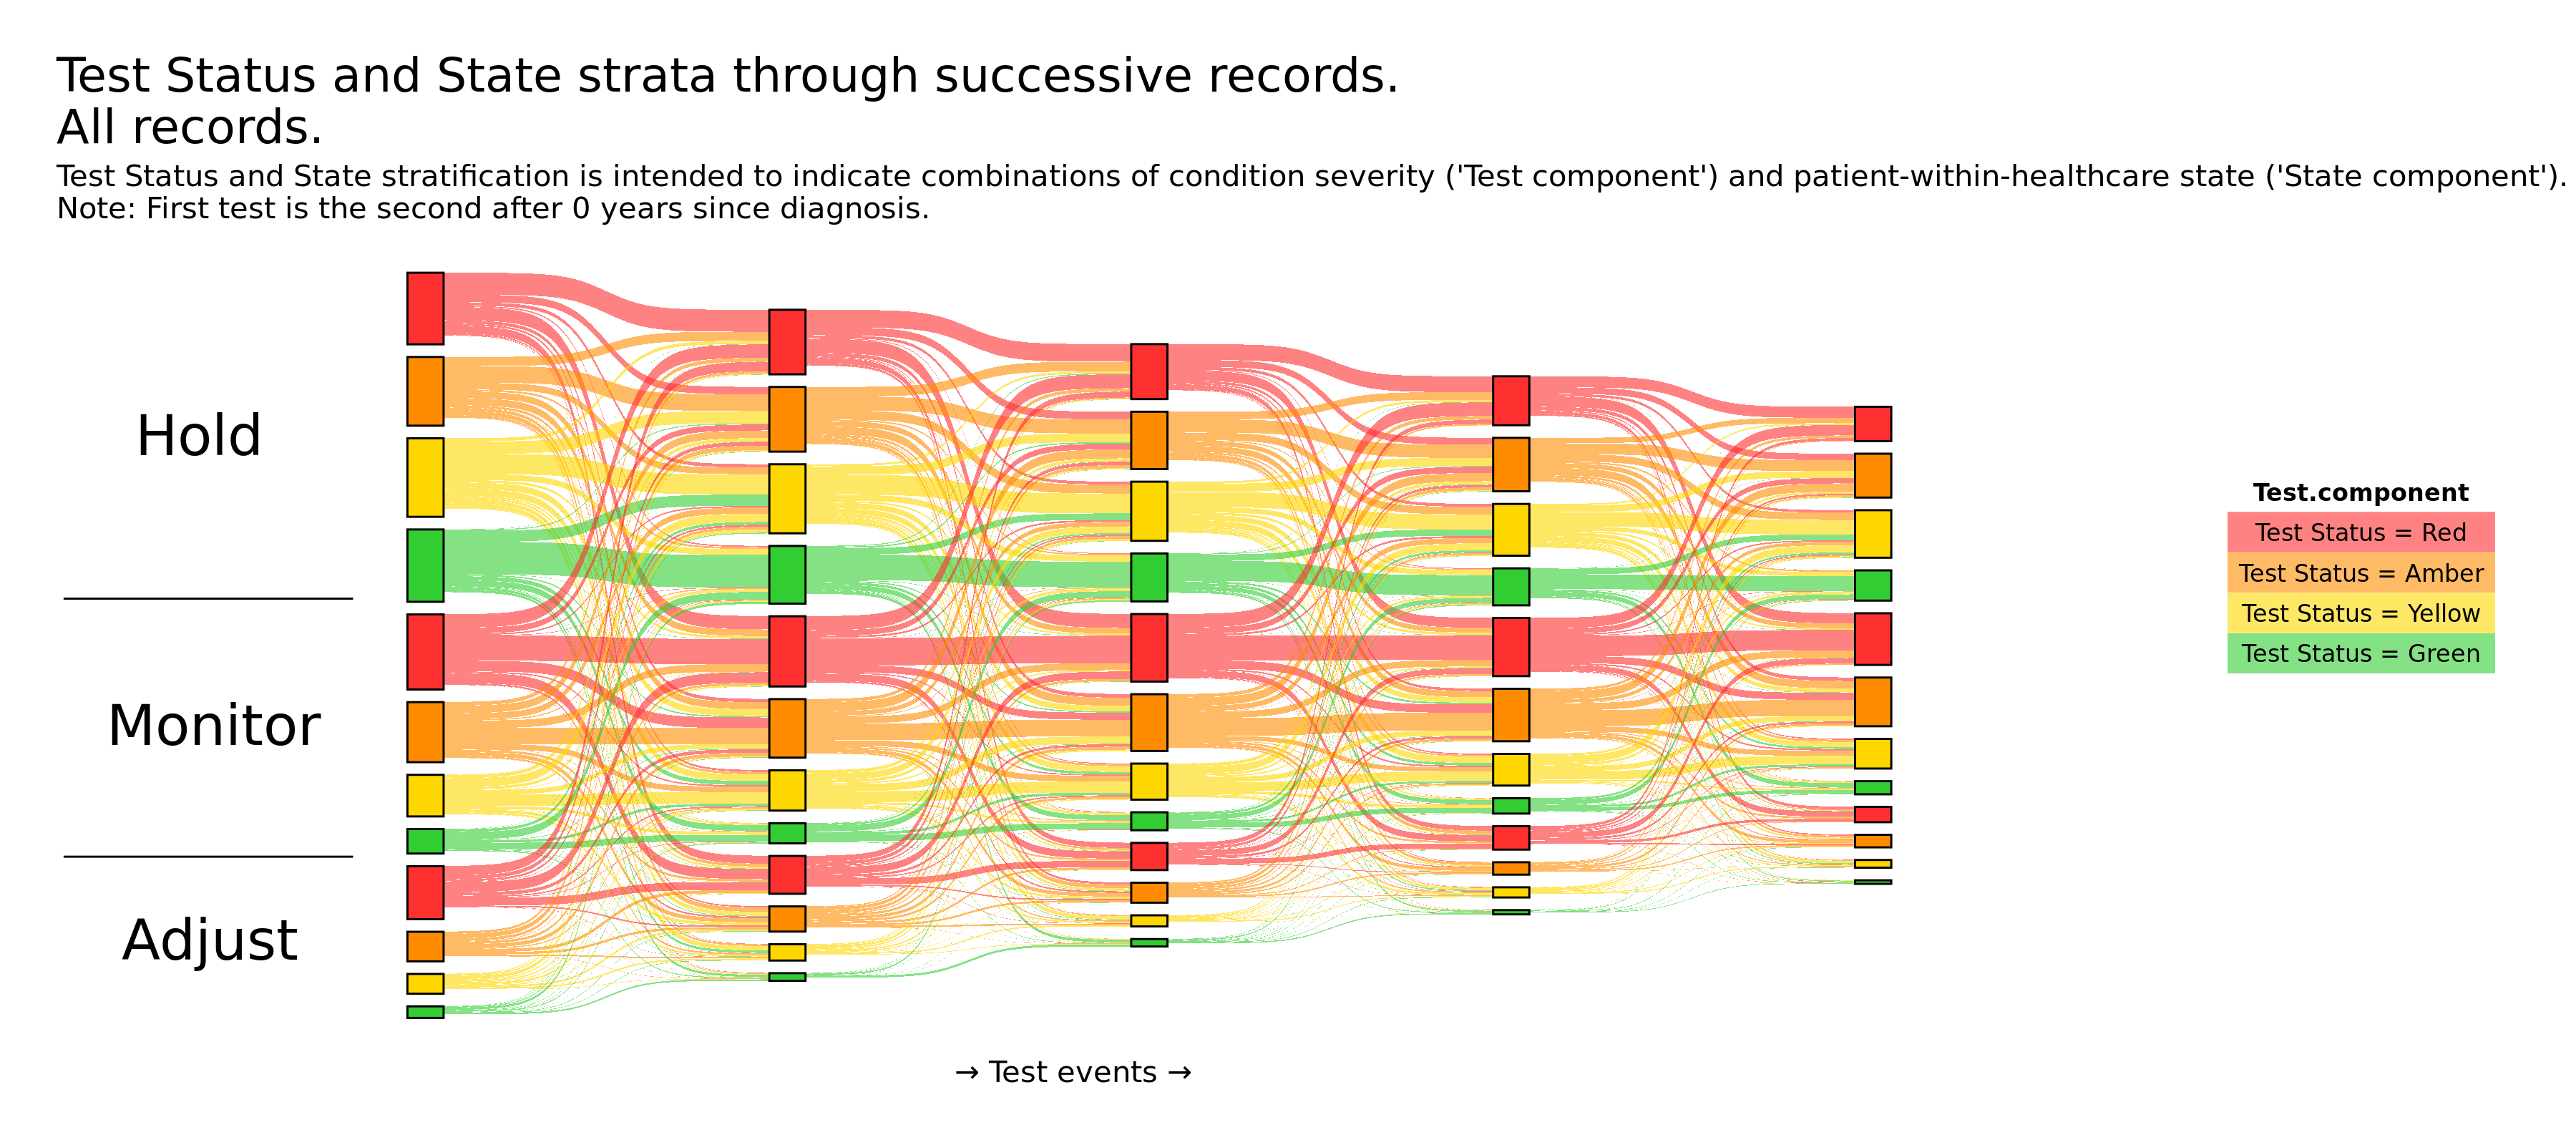

In [51]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()  %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a3", "a4", "a5", "a6", "a7" ) )

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate( group = 1 ) %>%
    dplyr::select( - next_x, - next_node, - next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -0.02, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = 0.02,  label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = 0.01,  label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records.\nAll records."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,paste0("Note: First test is the second after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) %>% head( -1 ) ) + # scales::alpha() is deciding the transparency of the bar colours.
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    HMAandTestStatus_display_table %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_tail( n = 5 ) %>%
    head( -1 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6) %>% head( -1 ), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_counts <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_counts ) )

The next three plots don't narrow because they plot data from cohorts that have all five test events. In other words, we have already filtered out any drop outs so the dropouts won't be represented as narrowing. 

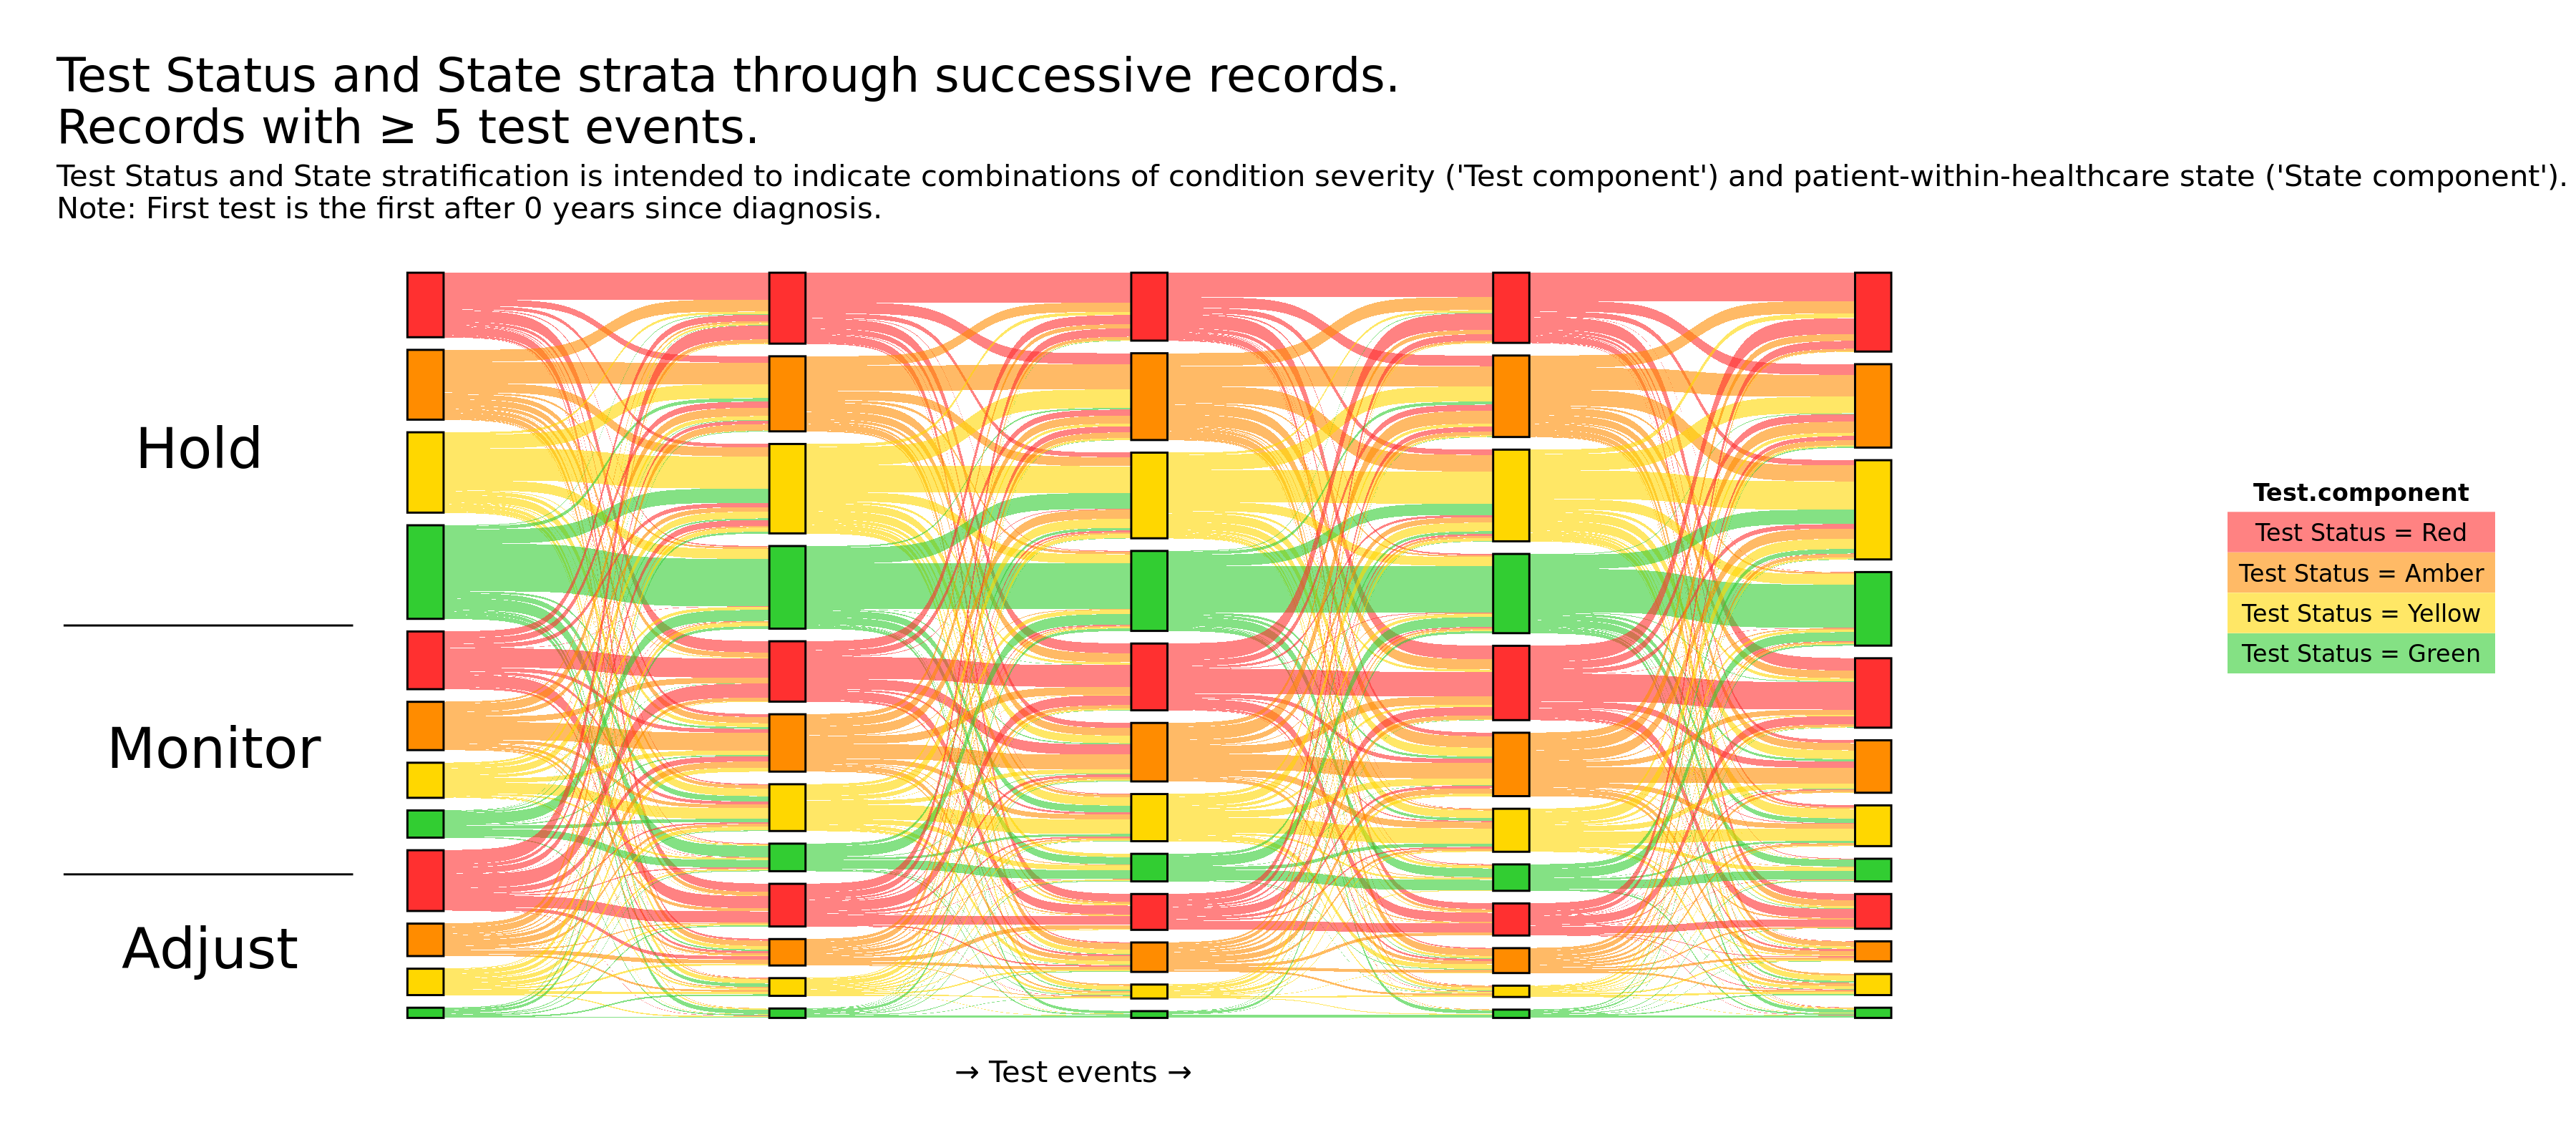

In [64]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # The following filter for the cohort with 5 or fewer tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_5 ) %>%
    tibble::column_to_rownames( "person_id" ) %>%
    # Remove the default start node.
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()  %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate( group = 1 ) %>%
    dplyr::select( - next_x, - next_node, - next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_5 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_5 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_5 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -0.02, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = 0.02,  label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = 0.01,  label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records.\nRecords with \u2265 5 test events."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    HMAandTestStatus_display_table %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_tail( n = 5 ) %>%
    head( -1 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_counts <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_counts ) )

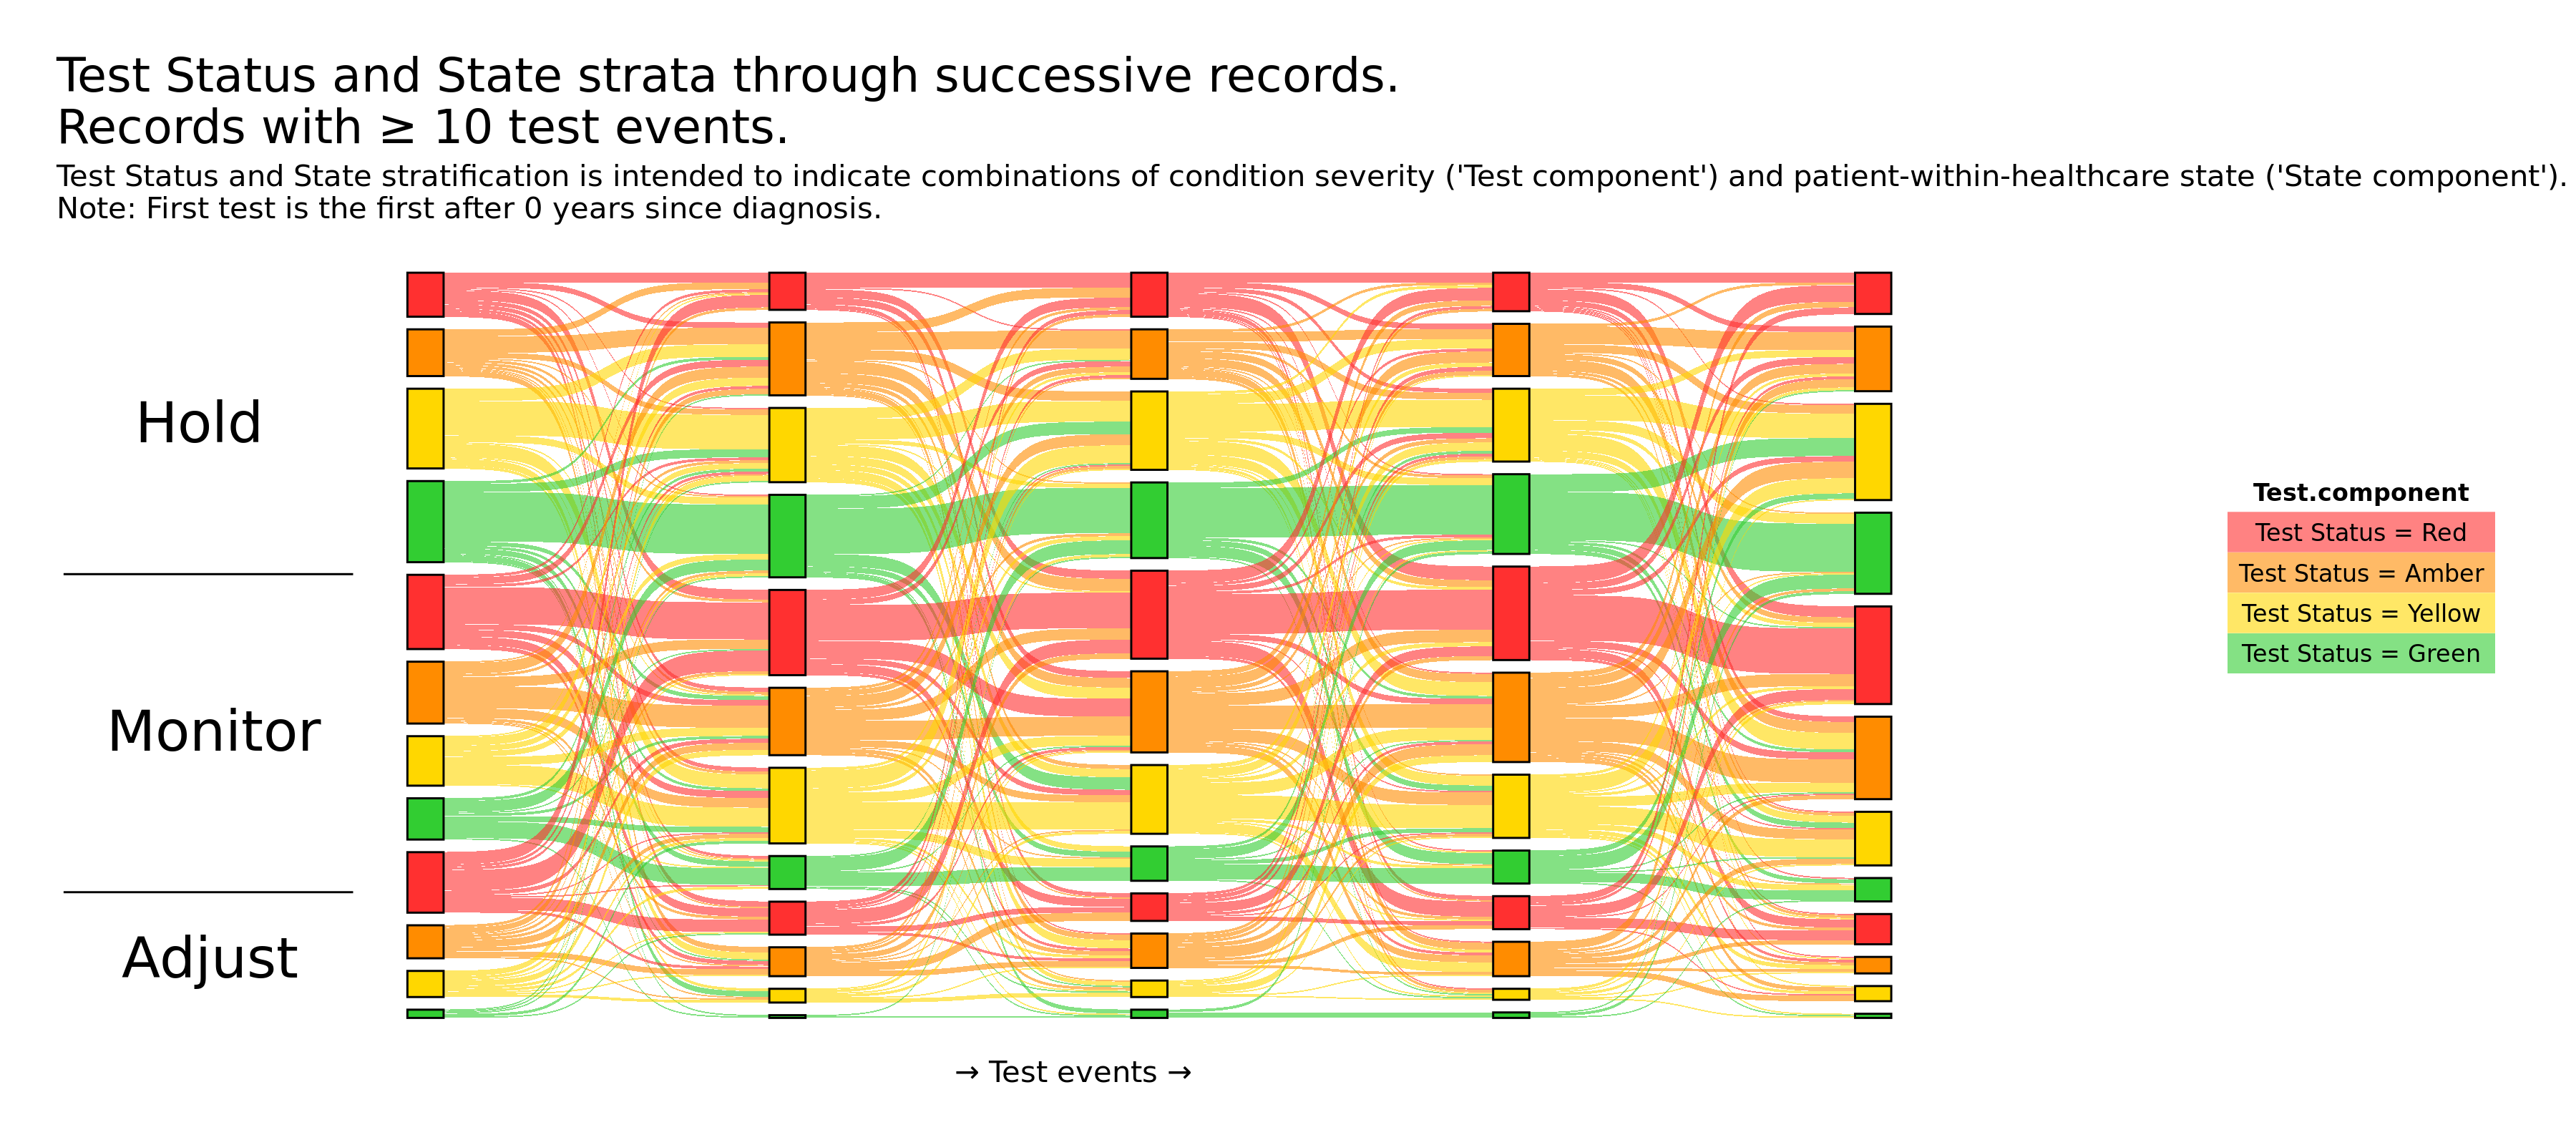

In [63]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # The following filter for the cohort with 10 or fewer tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_10 ) %>%
    tibble::column_to_rownames( "person_id" ) %>%
    # Remove the default start node.
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()  %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate( group = 1 ) %>%
    dplyr::select( - next_x, - next_node, - next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_10 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_10 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_10 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -0.02, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = 0.02,  label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = 0.01,  label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records.\nRecords with \u2265 10 test events."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    HMAandTestStatus_display_table %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_tail( n = 5 ) %>%
    head( -1 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_counts <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_counts ) )

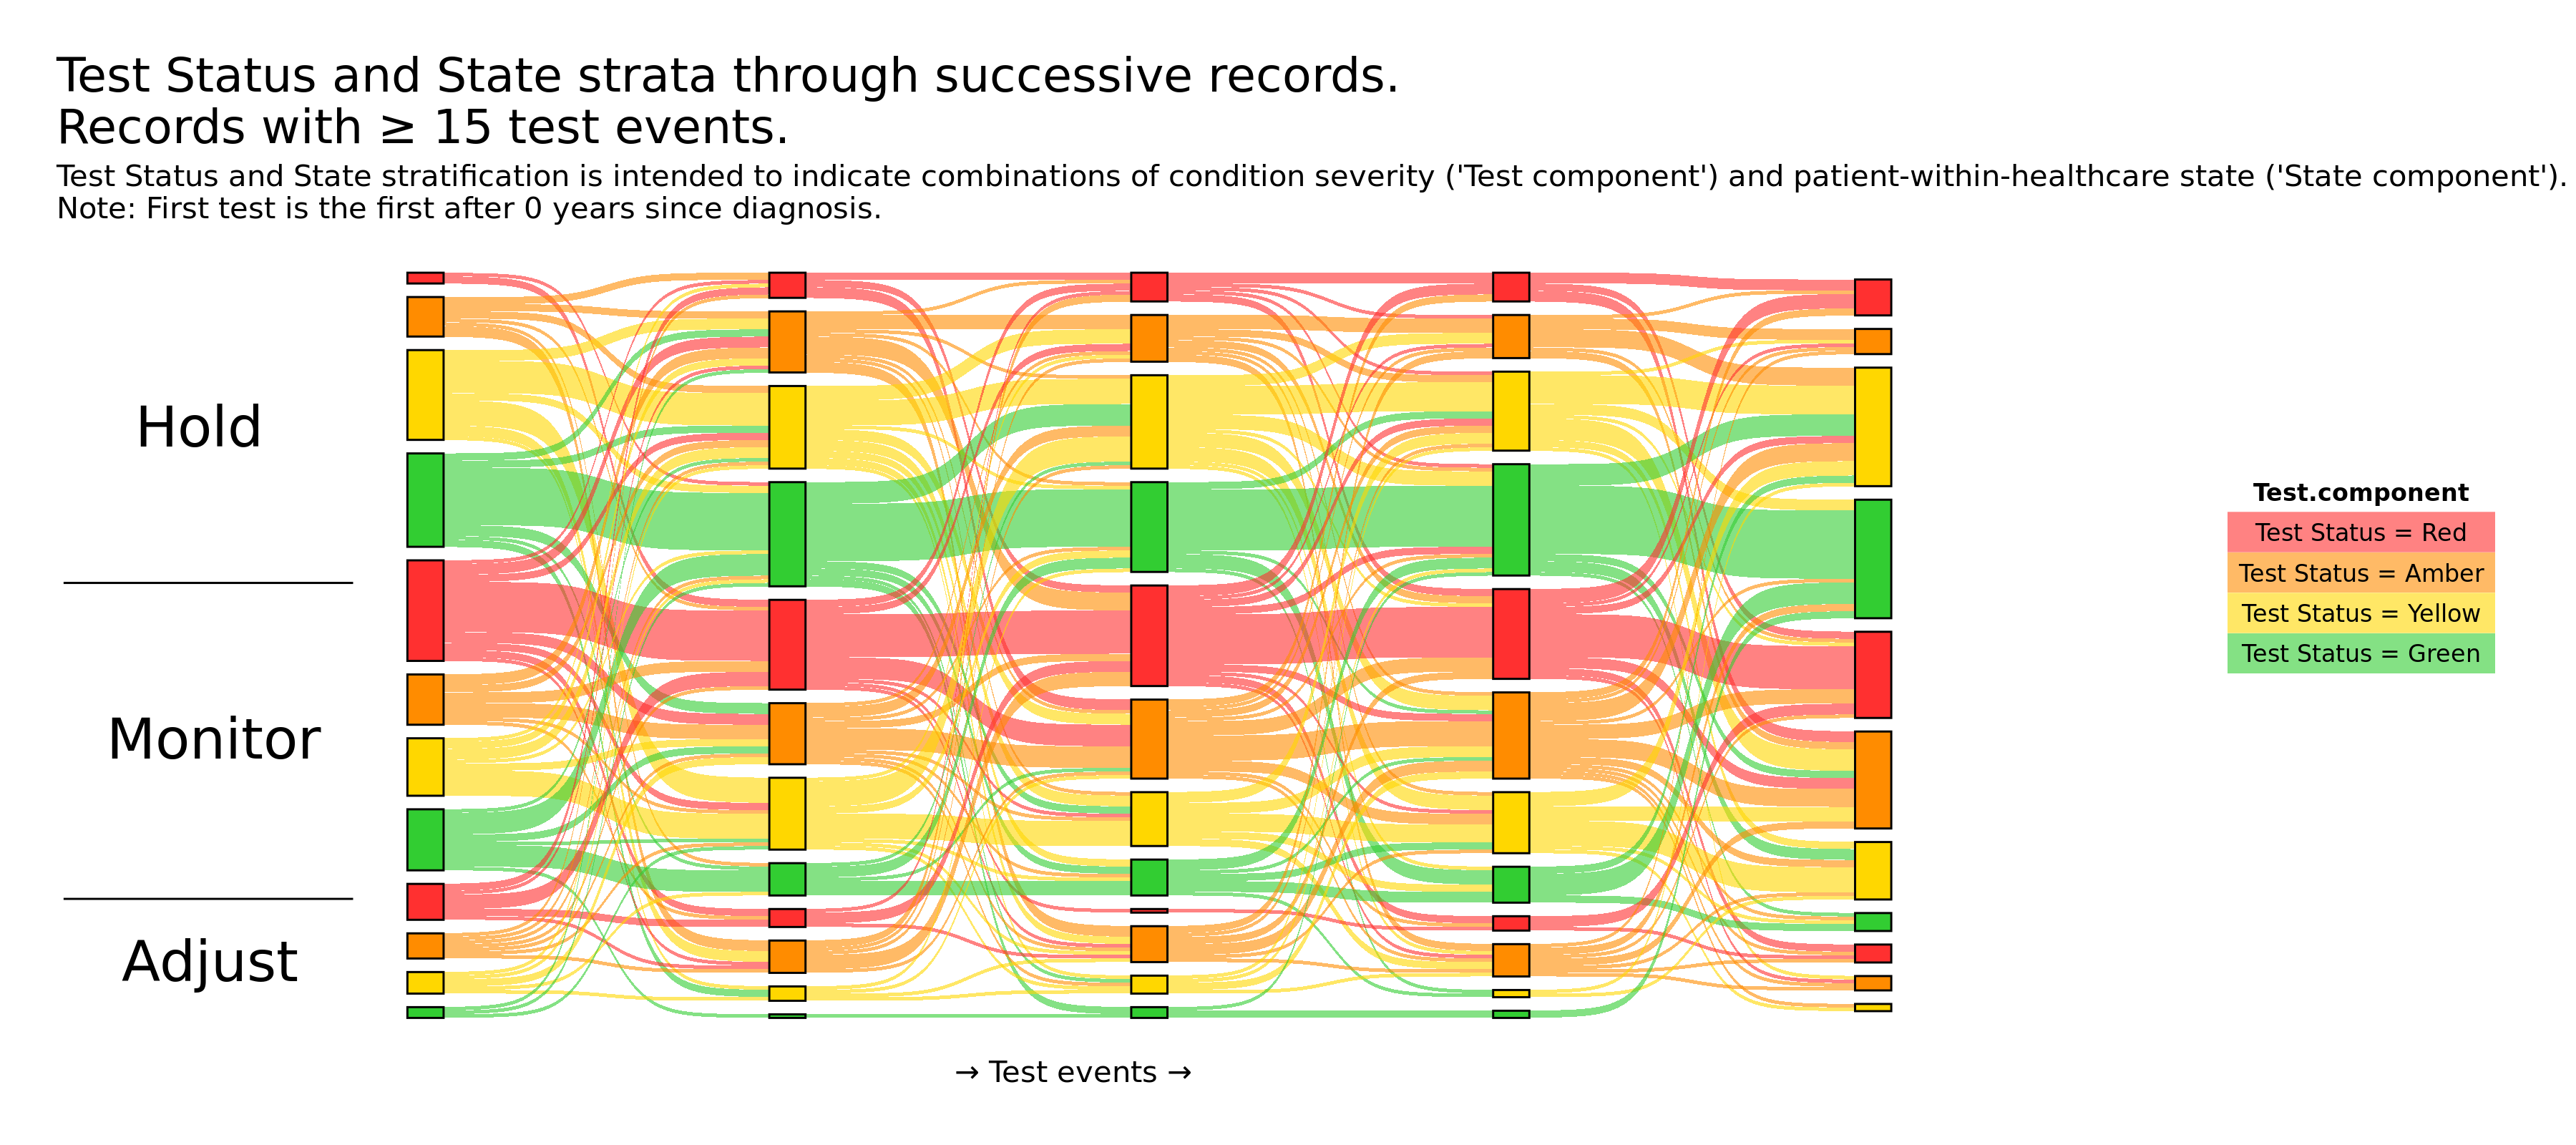

In [65]:
# Make plot data.
plotData <-
    sts_seqmine_HMAandTestStatus %>%
    # The following filter for the cohort with 20 or fewer tests on record.
    tibble::rownames_to_column( "person_id" ) %>%
    dplyr::filter( person_id %in% pids_atLeast_15 ) %>%
    tibble::column_to_rownames( "person_id" ) %>%
    # Remove the default start node.
    dplyr::select( - last_col() ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()  %>%
    dplyr::mutate(
        node = dplyr::if_else( node == "Unobserved", NA, node )
        ,next_node = dplyr::if_else( next_node == "Unobserved", NA, next_node )
    ) %>%
    dplyr::filter( !is.na( node ) ) %>%
    # Filter for only the first 5 test events.
    dplyr::filter( x %in% c( "a2", "a3", "a4", "a5", "a6" ) )

# Calculate where to place the line segment that divides the H.M.A. categories.
default_space <-
    plotData %>%
    dplyr::mutate( group = 1 ) %>%
    dplyr::select( - next_x, - next_node, - next_x) %>%
    dplyr::group_by_all() %>%
    dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
    dplyr::ungroup() %>%
    # The follow is adapted from ggsankey:::find_default_space().
    dplyr::group_by(x) %>%
    dplyr::summarise(n_groups = dplyr::n_distinct(node),
              freq = sum(freq, na.rm = TRUE)) %>%
    dplyr::mutate(v = freq / n_groups / 4) %>%
    dplyr::pull(v) %>%
    max()
n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_15 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Hold" ) ) %>% nrow()
n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_15 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Monitor" ) ) %>% nrow()
n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% tibble::rownames_to_column( "person_id" ) %>% dplyr::filter( person_id %in% pids_atLeast_15 ) %>% tibble::column_to_rownames( "person_id" ) %>% dplyr::filter( stringr::str_detect( a3, pattern = "Adjust" ) ) %>% nrow()
y_segment_Adjust <- n_patients_Adjust_at_start + ( 4 * default_space ) 
y_segment_Monitor <- y_segment_Adjust + n_patients_Monitor_at_start + ( 4.5 * default_space ) 
top <- y_segment_Monitor + n_patients_Hold_at_start +  ( 3 * default_space )
y_label_Hold <- y_segment_Monitor + ( ( ( 3 * default_space ) + n_patients_Hold_at_start ) / 2 )
y_label_Monitor <- y_segment_Monitor - ( ( ( 4 * default_space ) + n_patients_Monitor_at_start ) / 2 )
y_label_Adjust <- y_segment_Adjust - ( ( ( 4 * default_space ) + n_patients_Adjust_at_start ) / 2 )
y_segment_Adjust <- y_segment_Adjust - ( top / 2 )
y_segment_Monitor <- y_segment_Monitor - ( top / 2 )
y_label_Hold <- y_label_Hold - ( top / 2 )
y_label_Monitor <- y_label_Monitor - ( top / 2 )
y_label_Adjust <- y_label_Adjust - ( top / 2 )

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    # Plot Sankey.
    ggsankey::geom_sankey(
        flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
        ,node.color = 1
        #,space = 33
    ) +
    # Annotate the left side of the plot with labels.
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Monitor, yend = y_segment_Monitor ) +
    annotate("segment", x = 0, xend = 0.8, y = y_segment_Adjust, yend = y_segment_Adjust ) +
    annotate("text", x = -0.02, label = "\t\tHold", size = 10, y = y_label_Hold ) +
    annotate("text", x = 0.02,  label = "\t\tMonitor", size = 10, y = y_label_Monitor ) +
    annotate("text", x = 0.01,  label = "\t\tAdjust", size = 10, y = y_label_Adjust ) +
    labs(
        title = "Test Status and State strata through successive records.\nRecords with \u2265 15 test events."
        ,subtitle =
            paste0(
                "Test Status and State stratification is intended to indicate combinations of condition severity (\'Test component"
                ,"\') and patient-within-healthcare state (\'State component\').\n"
                ,paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    # Finish theme.
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,axis.title.y = element_blank()
        ,axis.text.x = element_blank()
        ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    HMAandTestStatus_display_table %>%
    dplyr::select( Test.component ) %>%
    dplyr::slice_tail( n = 5 ) %>%
    head( -1 ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        gridExtra::ttheme_minimal(
            core = list(
                bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    )           

# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_HMAandTestStatus_Sankey_counts <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 5/6, 1/6 )
    )

suppressWarnings( print( plot_HMAandTestStatus_Sankey_counts ) )